In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [691]:
import numpy as np
from numba import njit

from scipy import stats
from survivors.tree.stratified_model import KaplanMeier, FullProbKM, NelsonAalen, KaplanMeierZeroAfter
from survivors.metrics import ibs_WW, auprc
from survivors.constants import get_y

""" Auxiliary functions """


@njit('f4(f4[:], f4[:], f4[:], f4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    
#     plt.plot(N_1_j)
#     plt.plot(N_2_j)
#     plt.show()
    
    # N_1_j = np.cumsum(time_hist_1)
    # N_2_j = np.cumsum(time_hist_2)
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
    # print(N_1_j[0], N_2_j[0], np.sum(cens_hist_1), np.sum(cens_hist_2))
    # print(N_1_j, N_2_j, cens_hist_1, cens_hist_2)
    # print(ind)
    if ind.shape[0] == 0:
        return 0.0

    N_1_j = N_1_j[ind]  # + 1
    N_2_j = N_2_j[ind]  # + 1
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j  # np.abs(O_1_j - E_1_j)
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))

    # res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))  # TODO
    # res[:, 2] = E_1_j * (N_j - O_j + 1) * (N_2_j + 1) / ((N_j + 1) * (N_j))
    res[:, 0] = 1.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
    elif weightings == 6:
        res[:, 0] = O_j/N_j
    elif weightings == 7:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 8:
        res[:, 0] = (N_1_j*N_2_j)/N_j
        #res[:, 0] = np.cumprod((1.0 - O_1_j / (N_1_j + 1))) - np.cumprod((1.0 - O_2_j / (N_2_j + 1)))
    var = ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    num = res[:, 0] * res[:, 1]
    stat_val = np.power(num.sum(), 2) / var  # ((res[:, 0] * res[:, 0] * res[:, 2]).sum())

#     print("ALL:", N_j[0], "(", N_1_j[0], N_2_j[0], ")",
#           "OBS:", np.sum(O_j), "(", O_1_j, O_2_j, ")",  # ind,
#           "WEI:", res[:, 0],
#           # "OBS:", np.sum(O_j), "(", np.sum(cens_hist_1), np.sum(cens_hist_2), ")",
#           "STAT:", stat_val, "(", num, var, ")")

    if weightings == 7:
        res[:, 0] = 1 - res[:, 0]
        stat_val2 = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
        stat_val = max(stat_val, stat_val2)
    return stat_val  # It must be square of value (without sqrt)


def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        d.update({"diff": 6, "maxcombo": 7, "frac": 8})
        weightings = d.get(weightings, 1)
        logrank = lr_hist_statistic(time_hist_1.astype("float32"),
                                    time_hist_2.astype("float32"),
                                    cens_hist_1.astype("float32"),
                                    cens_hist_2.astype("float32"),
                                    np.uint32(weightings),
                                    weights_hist.astype("float32"))
        return logrank
    except Exception as err:
        # print(err)
        # print(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2, weights_hist)
        return 0.0

# def inverse_bincount_sf(time_hist, cens_hist):
#     evs = np.repeat(np.arange(1, time_hist.size + 1), cens_hist)
#     cns = np.repeat(np.arange(1, time_hist.size + 1), time_hist - cens_hist)
    
#     return get_y(time=np.hstack([evs, cns]),
#                cens=np.hstack([np.ones_like(evs), np.zeros_like(cns)]))

# def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weights_hist=None, weightings=""):
#     y_1 = inverse_bincount_sf(time_hist_1.astype(int), cens_hist_1.astype(int))
#     y_2 = inverse_bincount_sf(time_hist_2.astype(int), cens_hist_2.astype(int))
#     y_gl = np.hstack([y_1, y_2])
    
#     N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
#     N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    
#     N_j = N_1_j + N_2_j
#     O_j = cens_hist_1 + cens_hist_2
#     sf_gl = np.cumprod((1.0 - O_j / (N_j + 1)))
#     sf_1 = np.cumprod((1.0 - cens_hist_1 / (N_1_j + 1)))
#     sf_2 = np.cumprod((1.0 - cens_hist_2 / (N_2_j + 1)))
    
#     sf_gl = np.repeat(sf_gl[np.newaxis, :], y_gl.shape[0], axis=0)
    
#     sf_1 = np.repeat(sf_1[np.newaxis, :], y_1.shape[0], axis=0)
#     sf_2 = np.repeat(sf_2[np.newaxis, :], y_2.shape[0], axis=0)
# #     print(sf_gl, y_gl)

# #     ibs_gl = metr.auprc(y_gl, y_gl, sf_gl, np.arange(time_hist_1.shape[0]))
#     ibs_1 = metr.ibs_WW(y_1, y_1, sf_1, np.arange(time_hist_1.shape[0]))
#     ibs_2 = metr.ibs_WW(y_2, y_2, sf_2, np.arange(time_hist_1.shape[0]))
# #     return ibs_gl - ibs_1 + ibs_2 # (ibs_1*y_1.shape[0] + ibs_2*y_2.shape[0])/y_gl.shape[0]
#     return - ibs_1*y_1.shape[0] + ibs_2*y_2.shape[0]
    
    

def optimal_criter_split_hist(left_time_hist, left_cens_hist,
                              right_time_hist, right_cens_hist,
                              na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef):
    none_to = 0
    max_stat_val = 1.0

    if int(dis_coef) > 1:
        dis_coef = int(dis_coef)
        left_time_hist = left_time_hist + (dis_coef - 1) * left_cens_hist
        right_time_hist = right_time_hist + (dis_coef - 1) * right_cens_hist
        na_time_hist = na_time_hist + (dis_coef - 1) * na_cens_hist

        left_cens_hist = left_cens_hist * dis_coef
        right_cens_hist = right_cens_hist * dis_coef
        na_cens_hist = na_cens_hist * dis_coef
    elif dis_coef != 0:
        if int(1/dis_coef) > 1:
            cens_dc = int(1/dis_coef)
            left_time_hist = (cens_dc - 1)*left_time_hist + left_cens_hist
            right_time_hist = (cens_dc - 1)*right_time_hist + right_cens_hist
            na_time_hist = (cens_dc - 1)*na_time_hist + (dis_coef - 1) * na_cens_hist

            left_cens_hist = left_cens_hist * cens_dc
            right_cens_hist = right_cens_hist * cens_dc
            na_cens_hist = na_cens_hist * cens_dc

    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist, right_time_hist,
                             left_cens_hist + na_cens_hist, right_cens_hist,
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist, right_time_hist + na_time_hist,
                             left_cens_hist, right_cens_hist + na_cens_hist,
                             weights_hist, weightings=criterion)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
    #         print(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist, right_time_hist,
                                        left_cens_hist, right_cens_hist,
                                        weights_hist, weightings=criterion)
    return (max_stat_val, none_to)


def split_time_to_bins(time):
    return np.searchsorted(np.unique(time), time)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh + nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh + nan_sh, r_sh)
    return attrs


def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    # calculate information value
    # iv = ((p_bd - p_bd_)*woe_pl).sum()
    return (woe_x_feat, descr_np)


def get_sa_hists(time, cens, minlength=1, weights=None):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength)
#         time_hist = np.bincount(time, weights=weights, minlength=minlength)
#         cens_hist = np.bincount(time, weights=cens*weights, minlength=minlength)
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist


def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
#     plt.scatter([d["values"] for d in attr_dicts], [d["stat_val"] for d in attr_dicts])
#     plt.vlines([best_attr["values"]], ymin=0, ymax=best_attr["stat_val"], color="orange")
#     plt.show()
    
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        best_attr["src_val"] = best_attr['values']
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        # elif type_attr == "categ":
        #     best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr


def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, balance=False, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2 * min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    if np.sum(cens) == 0:
#         cens = np.ones_like(dur)
        return best_attr
    if weights is None:
        weights = np.ones_like(dur)
        '''
        kmf = KaplanMeierZeroAfter()
        kmf.fit(dur, cens)
        dd = np.unique(dur)
        sf = kmf.survival_function_at_times(dd)
        sf = np.repeat(sf[np.newaxis, :], dur.shape[0], axis=0)

        y = get_y(cens=cens, time=dur)
        weights = ibs_WW(y, y, sf, dd, axis=0)
        '''
        
    weights_hist = None

    dur = split_time_to_bins(dur)
    max_bin = dur.max()

    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]
    weights_notna = weights[~ind]

    dis_coef = 1
    if balance:
        dis_coef = (cens.shape[0] - np.sum(cens)) / np.sum(cens)
        # dis_coef = max(1, (cens.shape[0] - np.sum(cens)) // np.sum(cens))

    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr

    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i / float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:]) * 0.5
    uniq_set = np.unique(np.round(uniq_set, 3))

    index_vals_bin = np.digitize(vals_notna, uniq_set, right=True)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind],
                                              minlength=max_bin + 1, weights=weights[ind])
    # na_time_hist = na_time_hist  # * 20
    # na_cens_hist = na_cens_hist  # * 20

    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna,
                                            minlength=max_bin + 1, weights=weights_notna)
    # r_time_hist = r_time_hist  # * 20 + 1
    # r_cens_hist = r_cens_hist  # * 20 + 1
    # l_time_hist = np.zeros_like(r_time_hist, dtype=np.int32)  # + 1
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.float32)
    l_cens_hist = l_time_hist.copy()

    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    if criterion == "confident" or criterion == "confident_weights":
        kmf = KaplanMeier()
        if criterion == "confident_weights":
            kmf.fit(dur, cens, weights=weights)
        else:
            kmf.fit(dur, cens)
        ci = kmf.get_confidence_interval_()
        weights_hist = 1 / (ci[1:, 1] - ci[1:, 0] + 1e-5)  # (ci[1:, 1] + ci[1:, 0] + 1e-5)
        criterion = "weights"
    elif criterion == "fullprob":
        kmf = FullProbKM()
        kmf.fit(dur, cens)
        weights_hist = kmf.survival_function_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "ibswei":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        sf = kmf.survival_function_at_times(dd)
        sf = np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0)

        y_ = get_y(cens=np.ones_like(dd), time=dd)
        y_["cens"] = True
        ibs_ev = ibs_WW(y_, y_, sf, dd, axis=0)
        y_["cens"] = False
        ibs_cn = ibs_WW(y_, y_, sf, dd, axis=0)

        ratio = np.sum(cens)/cens.shape[0]
        weights_hist = ibs_ev*ratio + ibs_cn*(1-ratio)
        criterion = "weights"
    elif criterion == "T-ET":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        ET = np.trapz(kmf.survival_function_at_times(dd), dd)
        weights_hist = (dd - ET)  # **2
        criterion = "weights"
    elif criterion == "kde":
        na = NelsonAalen()
        na.fit(dur, cens, np.ones(len(dur)))
        weights_hist = na.get_smoothed_hazard_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "weights":
        weights_hist = np.bincount(dur, weights=weights,  # /sum(weights),
                                   minlength=max_bin + 1)
        #weights_hist /= np.bincount(dur, minlength=max_bin + 1)  # np.sqrt()
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]  # np.sqrt()

        weights_hist = weights_hist / weights_hist.sum()

    # for each split values get branches
    attr_dicts = []
    
#     min_times = []
#     stat_vals = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask], cens_notna[curr_mask],
                                                      minlength=max_bin + 1, weights=weights_notna[curr_mask])
        l_time_hist += curr_time_hist
        l_cens_hist += curr_cens_hist
        r_time_hist -= curr_time_hist
        r_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n

        if min(num_l, num_r) <= min_samples_leaf:
            continue
        
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef)
#         t1 = np.max(np.nonzero(l_time_hist))
#         t2 = np.max(np.nonzero(r_time_hist))
#         min_times.append(min(t1, t2))
#         stat_vals.append(max_stat_val)
        
        if max_stat_val > signif_stat:
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
            attr_dicts.append(attr_loc)
            
#     plt.scatter(min_times, stat_vals)
#     plt.show()
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    
#     plt.plot(weights_hist)
#     plt.show()
    
    '''
    fig, axes = plt.subplots(ncols=2)
    axes[0].plot(np.cumsum((l_time_hist + r_time_hist)[::-1])[::-1])
    axes[1].plot(l_cens_hist + r_cens_hist)
    axes[1].plot(l_time_hist + r_time_hist - (l_cens_hist + r_cens_hist), color="orange")
    plt.show()
    '''
    
    '''
    fig, axes = plt.subplots(ncols=2)
    cols = np.where(vals_notna <= best_attr["src_val"], "blue", "orange")
    axes[1].scatter(vals_notna, weights_notna, c=cols)
    axes[0].scatter(dur_notna, weights_notna, c=cols)
    plt.show()
    '''
    
    if verbose > 0:
        print(best_attr["p_value"], len(uniq_set))
    return best_attr

In [692]:
from survivors.tree.node import Node, Rule
from survivors.tree import CRAID

class Node1(Node):
    def find_best_split(self):
        numb_feats = self.info["max_features"]
        numb_feats = np.clip(numb_feats, 1, len(self.features))
        n_jobs = min(numb_feats, self.info["n_jobs"])

        selected_feats = list(np.random.choice(self.features, size=numb_feats, replace=False))
        # args = self.get_comb(selected_feats)
        args = self.get_comb_fast(selected_feats)

        ml = np.vectorize(lambda x: hist_best_attr_split(**x))(args)

        # with Parallel(n_jobs=n_jobs, verbose=self.verbose, batch_size=10) as parallel:  # prefer="threads"
        #     ml = parallel(delayed(hist_best_attr_split)(**a) for a in args)  # hist_best_attr_split
        attrs = {f: ml[ind] for ind, f in enumerate(selected_feats)}

#         attr = min(attrs, key=lambda x: attrs[x]["p_value"])
        attr = max(attrs, key=lambda x: attrs[x]["stat_val"])
        
#         print("STAT_VAL:", [v["stat_val"] for k, v in attrs.items()])
#         print("SIGN_SPLIT:", [v["sign_split"] for k, v in attrs.items()])
#         print("P_VALUES:", [v["p_value"] for k, v in attrs.items()])
        
#         attrs_gr = dict(filter(lambda x: x[1]["sign_split"] > 0, attrs.items()))
#         if len(attrs_gr) == 0:
#             attr = min(attrs, key=lambda x: attrs[x]["p_value"])
#         else:
#             attr = min(attrs_gr, key=lambda x: attrs_gr[x]["p_value"])
#             if self.info["bonf"]:
#                 attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]
            
#         if attrs[attr]["sign_split"] > 0 and self.info["bonf"]:
#             attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]
        return (attr, attrs[attr])
    
    def split(self):
        node_edges = np.array([], dtype=int)
        self.rule_edges = np.array([], dtype=Rule)
        
        attr, best_split = self.find_best_split()
        
        # The best split is not significant
        if best_split["sign_split"] == 0:
            if self.verbose > 0:
                print(f'Конец ветви, незначащее p-value: {best_split["p_value"]}')
            return node_edges
        if self.verbose > 0:
            print('='*6, best_split["p_value"], attr)

        branch_ind = self.ind_for_nodes(self.df[attr], best_split, attr in self.categ)

        for n_b in np.unique(branch_ind):
            rule = Rule(feature=attr,
                        condition=best_split["values"][n_b],
                        has_nan=best_split["pos_nan"][n_b])
            d_node = self.df[branch_ind == n_b].copy()
            N = Node1(df=d_node, full_rule=self.full_rule + [rule],
                     features=self.features, categ=self.categ,
                     depth=self.depth + 1, verbose=self.verbose, **self.info)
            node_edges = np.append(node_edges, N)
            self.rule_edges = np.append(self.rule_edges, rule)

        if self.rule_edges.shape[0] == 1:
            print(branch_ind, self.df[attr], best_split, attr in self.categ)
            raise ValueError('ERROR: Only one branch created!')

        return node_edges

class CRAID1(CRAID):
    def fit(self, X, y):
        if len(self.features) == 0:
            self.features = X.columns
        self.bins = cnt.get_bins(time=y[cnt.TIME_NAME])  # , cens = y[cnt.CENS_NAME])
        X = X.reset_index(drop=True)
        X_tr = X.copy()
        X_tr[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X_tr[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        if not ("min_samples_leaf" in self.info):
            self.info["min_samples_leaf"] = 0.01
        if isinstance(self.info["min_samples_leaf"], float):
            self.info["min_samples_leaf"] = max(int(self.info["min_samples_leaf"] * X_tr.shape[0]), 1)

        cnt.set_seed(self.random_state)

        if self.balance in ["balance", "balance+correct"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()
            self.correct_proba = freq[1] / (freq[1] + freq[0])  # or freq[1] / (freq[0])

            X_tr = get_oversample(X_tr, target=cnt.CENS_NAME)
        elif self.balance in ["balance+weights"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()

            X_tr["weights_obs"] = np.where(X_tr[cnt.CENS_NAME], freq[0] / freq[1], 1)
            self.info["weights_feature"] = "weights_obs"
        elif self.balance in ["only_log_rank"]:
            self.info["balance"] = True

        if self.cut:
            X_val = X_tr.sample(n=int(0.2 * X_tr.shape[0]), random_state=self.random_state)
            X_tr = X_tr.loc[X_tr.index.difference(X_val.index), :]

        self.nodes[0] = Node1(X_tr, features=self.features, categ=self.categ, **self.info)
        stack_nodes = np.array([0], dtype=int)
        while stack_nodes.shape[0] > 0:
            node = self.nodes[stack_nodes[0]]
            stack_nodes = stack_nodes[1:]
            if node.depth >= self.depth:
                continue
            sub_nodes = node.split()
            if sub_nodes.shape[0] > 0:
                sub_numbers = np.array([len(self.nodes) + i for i in range(sub_nodes.shape[0])])
                for i in range(sub_nodes.shape[0]):
                    sub_nodes[i].numb = sub_numbers[i]
                self.nodes.update(dict(zip(sub_numbers, sub_nodes)))
                node.set_edges(sub_numbers)
                stack_nodes = np.append(stack_nodes, sub_numbers)

        if self.cut:
            self.cut_tree(X_val, cnt.CENS_NAME, mode_f=roc_auc_score, choose_f=max)

        # self.fit_cox_hazard(X, y)
        return

In [693]:
class BootstrapCRAID1(BootstrapCRAID):
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.y_train = y
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_cr = cnt.pd_to_xy(x_sub)

            model = CRAID1(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_cr)

            self.add_model(model, x_oob)
        print(f"fitted: {len(self.models)} models.")

In [694]:
from survivors.ensemble import BoostingCRAID

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]
            
#             plt.scatter(y_sub_tr["time"], self.weights[x_sub['ind_start']])
#             plt.show()
            
            model = CRAID1(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        # PRED WEI!!!
        ibs_sf = metr.ibs_WW(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        
#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#             ibs_ens = metr.ibs_WW(self.y_train, y_sub, pred_ens, self.bins)
#             betta = ibs_ens / np.mean(ibs_sf)
#         else:
#             betta = 1
#         wei = ibs_sf

        if len(self.bettas) > 0:
            pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
            
            ibs_ens = metr.ibs_WW(self.y_train, y_sub, pred_ens, self.bins)
            
            betta = ibs_ens / np.mean(ibs_sf)
            # betta = ibs_ens / np.mean(ibs_sf)
            print(betta, np.mean(ibs_sf), np.std(ibs_sf))
            wei = (ibs_ens + (betta**2) * ibs_sf)/(1+ betta)**2
        else:
            betta = 1
            wei = ibs_sf
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
        # PRED WEI!!!
#         if len(self.models) > 1:
#             self.weights = self.weights + (self.bettas[-1]**2) * wei_i
#             self.weights /= (1 + self.bettas[-1])**2
#             self.bettas = list(np.array(self.bettas)/np.sum(self.bettas))
#         else:
#             self.weights = wei_i
        self.weights += wei_i

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs"):
        res = []
        metr_vals = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))

            res_all = np.array(res)
            res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
            res_all[:, -1] = 0
            res_all[:, 0] = 1
            if metric == "ibs":
                metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
            else:
                metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
        plt.plot(range(len(self.models)), metr_vals, label=label)

In [695]:
from survivors.ensemble import BoostingCRAID

class IBSCRAID1(CRAID1):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None

    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        
        sf = self.predict_at_times(X, bins=self.bins, mode="surv")
        ibs_ex = metr.auprc(y, y, sf, self.bins, axis=0)
        
        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_ex)
        self.ibs_leaf[counts > 0] /= counts[counts > 0]

    def get_ibs_by_leaf(self, X):
        numbs = self.predict(X, target="numb").astype("int")
        return self.ibs_leaf[numbs]

    def fit(self, X, y):
        super().fit(X, y)
        # self.set_ibs_by_leaf(X, y)

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = list(X.columns)
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X.copy()
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']].copy()
#                 if len(self.bettas) > 0:
#                     X_sub_tr["weights_obs"] /= np.sum(self.bettas)
            
#             print(np.sum(self.bettas))
#             if len(self.bettas) > 0:
#                 plt.scatter(self.X_train["time"], self.weights / np.sum(self.bettas), 
#                             c=np.where(self.X_train["cens"], "orange", "blue"))
#                 plt.show()
#             else:
            plt.scatter(self.X_train["time"], self.weights, 
                        c=np.where(self.X_train["cens"], "orange", "blue"))
            plt.show()
                
            
            model = IBSCRAID1(features=self.features.copy(), random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            #self.X_train[f"ibs_feature_{i}"] = model.get_ibs_by_leaf(self.X_train)
            #self.features.append(f"ibs_feature_{i}")

    def predict(self, x_test_, aggreg=True, **kwargs):
        res = []
        weights = []
        x_test = x_test_.copy()
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
            # x_test[f"ibs_feature_{i}"] = self.models[i].get_ibs_by_leaf(x_test)

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test_, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        x_test = x_test_.copy()
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))
            # x_test[f"ibs_feature_{i}"] = self.models[i].get_ibs_by_leaf(x_test)

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        # PRED WEI!!!
        y_sub_ = y_sub.copy()
#         y_sub_["cens"] = 1
        ibs_sf = metr.ibs_remain(self.y_train, y_sub_, pred_sf, self.bins, axis=0)
        
#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#             ibs_ens = metr.ibs_WW(self.y_train, y_sub, pred_ens, self.bins)
#             betta = ibs_ens / np.mean(ibs_sf)
#         else:
#             betta = 1
#         wei = ibs_sf

#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
            
#             ibs_ens = metr.ibs_WW(self.y_train, y_sub, pred_ens, self.bins)
            
#             betta = ibs_ens / np.mean(ibs_sf)
#             # betta = ibs_ens / np.mean(ibs_sf)
#             print(betta, np.mean(ibs_sf), np.std(ibs_sf))
#             wei = (ibs_ens + (betta**2) * ibs_sf)/(1+ betta)**2
#         else:
        wei = ibs_sf
        # wei = self.weights * ibs_sf / np.sum(self.weights)
        betta = 1/np.mean(ibs_sf)
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
        # PRED WEI!!!
#         if len(self.models) > 1:
#             self.weights = self.weights + (self.bettas[-1]**2) * wei_i
#             self.weights /= (1 + self.bettas[-1])**2
#             self.bettas = list(np.array(self.bettas)/np.sum(self.bettas))
#         else:
#             self.weights = wei_i

        if len(self.models) > 1:
            self.weights += (self.bettas[-1]) * wei_i
        else:
            self.weights = (self.bettas[-1]) * wei_i
        # self.weights = 1 + (wei_i > (len(self.models) / np.sum(self.bettas)))

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs"):
        res = []
        metr_vals = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))

            res_all = np.array(res)
            res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
            res_all[:, -1] = 0
            res_all[:, 0] = 1
            if metric == "ibs":
                metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
            else:
                metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
        plt.plot(range(len(self.models)), metr_vals, label=label)

In [725]:
from survivors.ensemble import BoostingCRAID

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = list(X.columns)
        X = X.reset_index(drop=True).copy()
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X.copy()
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y.copy()

        self.weights = y[cnt.TIME_NAME].copy()
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()
        self.lr = 1

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub.copy())
            y_sub_tr[cnt.TIME_NAME] = self.weights[x_sub['ind_start'].values].copy()
            
            plt.scatter(self.y_train["time"], self.weights, c=np.where(self.y_train["cens"], "orange", "blue"))
            plt.show()
            
            model = IBSCRAID1(features=self.features.copy(), random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr.copy(), y_sub_tr.copy())
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'].values, wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train.copy()
            y_sub = self.y_train.copy()
        
        y_sub["time"] = self.weights[X_sub['ind_start'].values]
        # pred_time = model.predict(X_sub, target="time")
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        pred_time = self.bins[(pred_sf <= 0.5).argmax(axis=1)]
        ibs_sf = metr.ibs_remain(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        
        wei = (y_sub["time"] - pred_time) * ibs_sf  # (2*y_sub["cens"] - 1) * 
        if len(self.models) > 0:
            betta = self.lr/np.mean(ibs_sf)
        else:
            betta = self.lr/np.mean(ibs_sf)
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
#         print(index, wei_i)
        self.lr = 0.05
        if self.all_weight:
            self.weights -= wei_i * self.lr
        else:
            self.weights[index] -= wei_i * self.lr
            
    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs"):
        res = []
        metr_vals = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))

            res_all = np.array(res)
            res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
            res_all[:, -1] = 0
            res_all[:, 0] = 1
            if metric == "ibs":
                metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
            else:
                metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
        plt.plot(range(len(self.models)), metr_vals, label=label)

In [726]:
from sklearn.model_selection import train_test_split
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
# # y["time"] += 1

# # y["cens"] = ~y["cens"]
# features = list(set(features) - {"max_2019_nCoV_nucleic_acid_detection", 
#                                  "mean_2019_nCoV_nucleic_acid_detection", 
#                                  "min_2019_nCoV_nucleic_acid_detection"})
# X = X[features]

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

In [698]:
from survivors.tree import CRAID
from survivors.tree.node import Node

tree = Node(df, features=features, criterion="logrank", depth=10, min_samples_leaf=2)

In [699]:
tree.info

{'criterion': 'logrank',
 'min_samples_leaf': 2,
 'bonf': True,
 'n_jobs': 16,
 'max_features': 8,
 'signif': 1.1,
 'signif_stat': 0.0,
 'thres_cont_bin_max': 100,
 'weights_feature': None,
 'leaf_model': 'base'}

In [700]:
kmf = KaplanMeierZeroAfter()
kmf.fit(y["time"], y["cens"])

dd = np.unique(y["time"])
sf = kmf.survival_function_at_times(dd)
sf = np.repeat(sf[np.newaxis, :], y.shape[0], axis=0)

ibs_full = ibs_WW(y, y, sf, dd, axis=0)

y_ = y.copy()
y_["cens"] = True
ibs_ev = ibs_WW(y, y_, sf, dd, axis=0)
y_["cens"] = False
ibs_cn = ibs_WW(y, y_, sf, dd, axis=0)

ratio = np.sum(y["cens"])/y.shape[0]
weights_hist = ibs_ev*ratio + ibs_cn*(1-ratio)

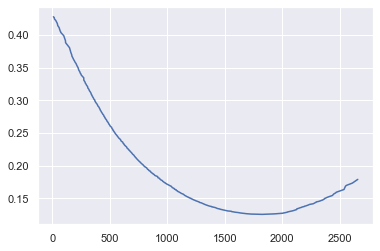

In [701]:
plt.plot(np.sort(y["time"]), ibs_ev[np.argsort(y["time"])])

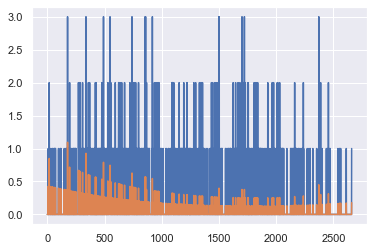

In [9]:
n_w = np.cumsum(np.bincount(y["time"].astype(int), weights=ibs_ev)[::-1])[::-1]
o_w = np.bincount(y["time"].astype(int), weights=ibs_ev)

n_j = np.cumsum(np.bincount(y["time"].astype(int))[::-1])[::-1]
o_j = np.bincount(y["time"].astype(int))

# plt.plot(n_w)
# plt.plot(n_j)

# plt.plot(n_w/n_j)
# plt.plot(o_w[o_w>0]/o_j[o_w>0])

plt.plot(np.bincount(y["time"].astype(int)))
plt.plot(np.bincount(y["time"].astype(int), weights=ibs_ev))

In [10]:
def ind_for_nodes(X_attr, best_split_, is_categ):
    rule_id = best_split_["pos_nan"].index(0)
    query = best_split_["values"][rule_id]
    if is_categ:
        values = np.isin(X_attr, eval(query[query.find("["):]))
    else:
        values = eval("X_attr" + query)
    return np.where(values, rule_id, 1 - rule_id)

def fit_predict_KM(X_):
    y_ = get_y(time=X_[-1], cens=X_[-2])
#     print(y_["time"])
    kmf = KaplanMeierZeroAfter()
    kmf.fit(y_["time"], y_["cens"])
    sf = kmf.survival_function_at_times(bins_HO)
    sf = np.repeat(sf[np.newaxis, :], y_.shape[0], axis=0)
    print(f"IBS:{ibs_WW(y_, y_, sf, bins_HO):.5f}, AUPRC:{auprc(y_, y_, sf, bins_HO):.5f}, {X_.shape[1]}")

def get_ibs(X_, best_split_, f, is_categ):
    fit_predict_KM(X_)
    inds = ind_for_nodes(X_[f], best_split_, is_categ)
    fit_predict_KM(X_[:, np.where(inds == 0)[0]])
    fit_predict_KM(X_[:, np.where(inds == 1)[0]])

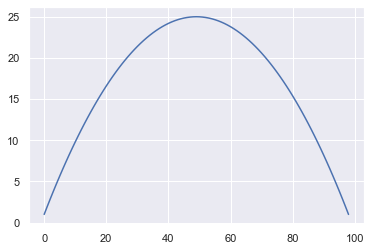

In [11]:
n1 = np.arange(1, 100)
plt.plot((n1*(100-n1))/100)

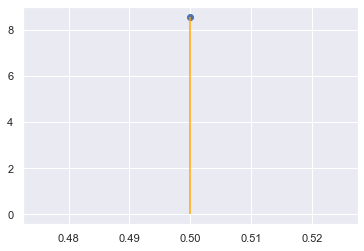

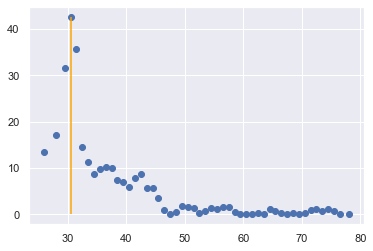

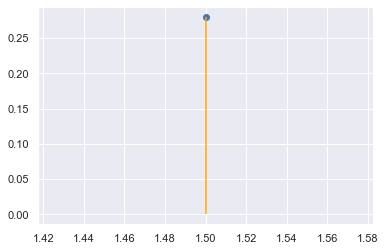

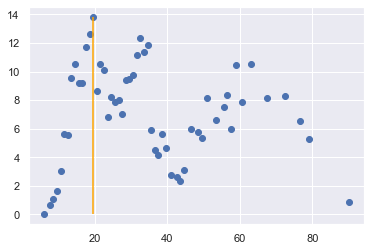

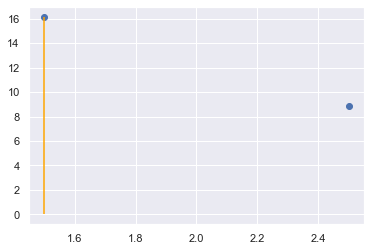

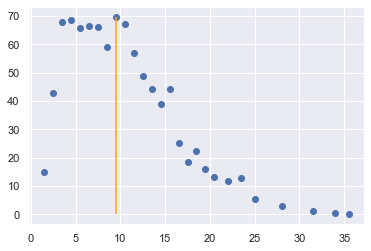

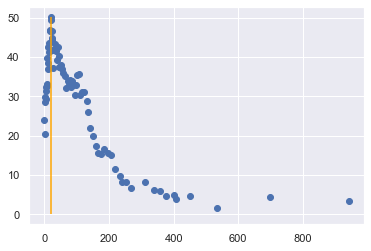

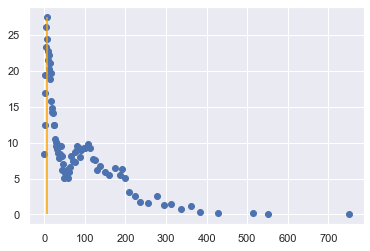

posnodal BEST FEATURE
IBS:0.14133, AUPRC:0.58551, 686
IBS:0.13392, AUPRC:0.61848, 583
IBS:0.12030, AUPRC:0.54653, 103


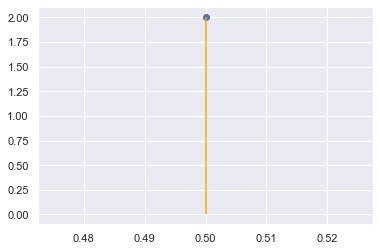

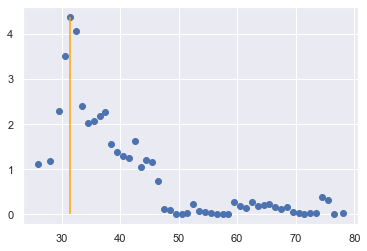

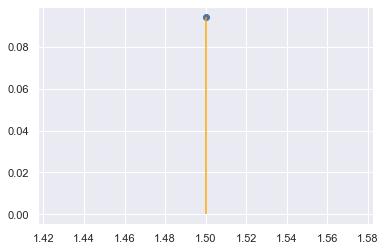

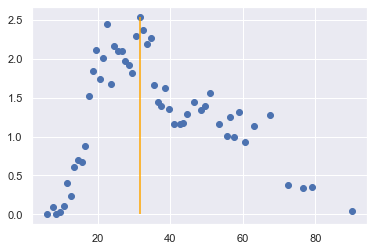

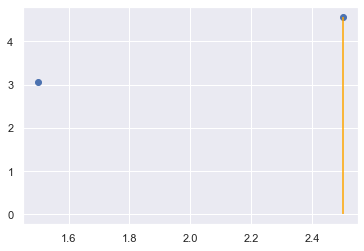

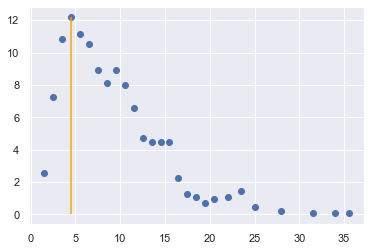

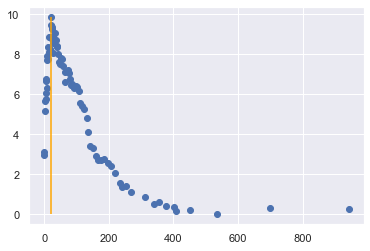

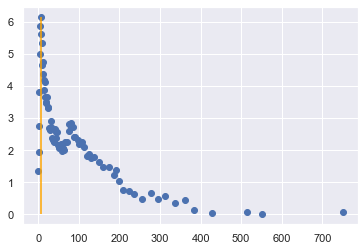

posnodal BEST FEATURE
IBS:0.14133, AUPRC:0.58551, 686
IBS:0.12319, AUPRC:0.65621, 433
IBS:0.13819, AUPRC:0.52758, 253


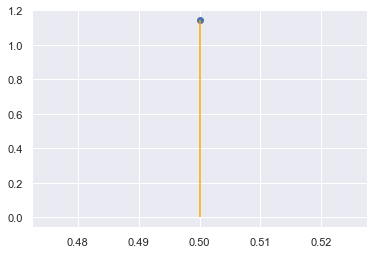

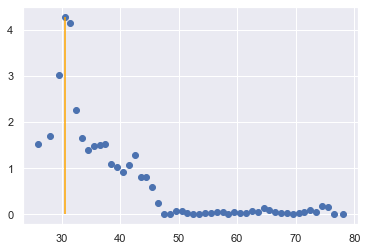

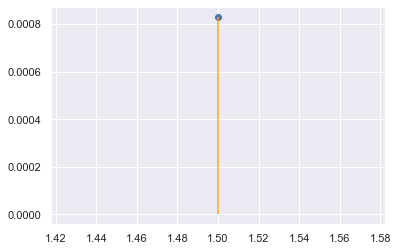

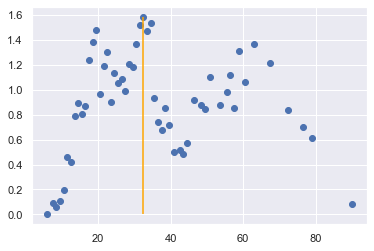

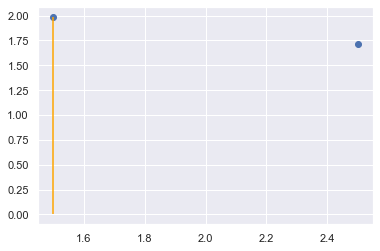

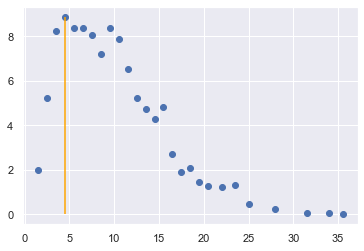

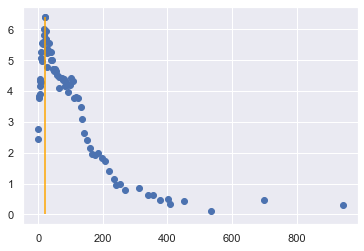

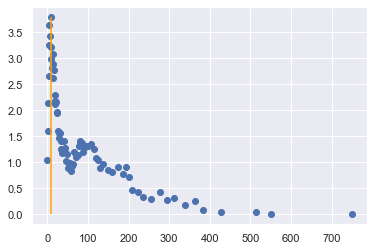

posnodal BEST FEATURE
IBS:0.14133, AUPRC:0.58551, 686
IBS:0.12319, AUPRC:0.65621, 433
IBS:0.13819, AUPRC:0.52758, 253


In [12]:
X_ = df.loc[:, features + [cnt.CENS_NAME, cnt.TIME_NAME]].to_numpy().T
for i_w, w in enumerate([np.ones(X_.shape[1]), ibs_full, weights_hist]):
    attr_by = {}
    for i_f, f in enumerate(features):
        d = tree.info.copy()
        d["arr"] = np.vstack((X_[i_f], X_[-2:]))
        d["type_attr"] = ("woe" if tree.woe else "categ") if f in tree.categ else "cont"
        d["weights"] = w
        a = hist_best_attr_split(**d)
        #print(f, w[:5], a)
        #get_ibs(X_, a, i_f, d["type_attr"] == "categ")
        attr_by[f] = a

    attr = max(attr_by, key=lambda x: attr_by[x]["stat_val"])
    print(attr, "BEST FEATURE")
    get_ibs(X_, attr_by[attr], features.index(attr), attr in tree.categ)

In [291]:
from survivors.tree.stratified_model import KaplanMeier, FullProbKM, NelsonAalen, KaplanMeierZeroAfter

y_sub = y[:100].copy()

kmf1 = KaplanMeierZeroAfter()
kmf1.fit(y_sub["time"], y_sub["cens"])

dd = np.unique(y_sub["time"])
sf1 = kmf1.survival_function_at_times(bins_HO)
sf1 = np.repeat(sf1[np.newaxis, :], y_sub.shape[0], axis=0)

ibs_full1 = ibs_WW(y_sub, y_sub, sf1, bins_HO, axis=0)
print(ibs_full1, auprc(y_sub, y_sub, sf1, bins_HO))


kmf2 = KaplanMeierZeroAfter()
kmf2.fit(y_sub["time"], y_sub["cens"], weights=ibs_full1)

dd = np.unique(y_sub["time"])
sf2 = kmf2.survival_function_at_times(bins_HO)
sf2 = np.repeat(sf2[np.newaxis, :], y_sub.shape[0], axis=0)

ibs_full2 = ibs_WW(y_sub, y_sub, sf2, bins_HO, axis=0)
print(ibs_full2, auprc(y_sub, y_sub, sf2, bins_HO))


kmf3 = KaplanMeierZeroAfter()
kmf3.fit(y_sub["time"], y_sub["cens"], weights=ibs_full2)

dd = np.unique(y_sub["time"])
sf3 = kmf3.survival_function_at_times(bins_HO)
sf3 = np.repeat(sf3[np.newaxis, :], y_sub.shape[0], axis=0)

ibs_full3 = ibs_WW(y_sub, y_sub, sf3, bins_HO, axis=0)
print(ibs_full3, auprc(y_sub, y_sub, sf3, bins_HO))


# na = NelsonAalen()  # KaplanMeierZeroAfter()
# na.fit(y_sub["time"], y_sub["cens"]) #, weights=np.random.rand(y_sub["time"].shape[0]))

# sf_na = np.exp(-na.cumulative_hazard_at_times(bins_HO))
# sf_na[bins_HO > na.timeline[-1]] = 0
# sf_na[bins_HO < na.timeline[0]] = 1
# sf_na = np.repeat(sf_na[np.newaxis, :], y_sub.shape[0], axis=0)

# ibs_full = ibs_WW(y_sub, y_sub, sf_na, bins_HO, axis=0)
# print(ibs_full.mean(), np.dot(wei, ibs_full), auprc(y_sub, y_sub, sf_na, bins_HO))

[0.14463207 0.15604534 0.21081328 0.14439137 0.20114321 0.26506728
 0.15786795 0.15604115 0.25933904 0.1317297  0.2359465  0.35512945
 0.10723948 0.10752097 0.10456526 0.14777515 0.21170138 0.0951568
 0.09962246 0.18856586 0.1428139  0.09022106 0.09022106 0.08928092
 0.28475645 0.16332179 0.24166586 0.15093338 0.06670991 0.07571425
 0.06535632 0.06564637 0.05324346 0.05388015 0.15904081 0.05324346
 0.19759744 0.04362981 0.04346779 0.04144254 0.03250391 0.03286623
 0.26480973 0.02461789 0.01587946 0.19116562 0.16799841 0.31609748
 0.11019519 0.16545391 0.14332852 0.08928092 0.14321575 0.36136391
 0.32115076 0.20760724 0.13910169 0.10906921 0.10920995 0.08394387
 0.24251844 0.08624816 0.29302465 0.10079764 0.08834078 0.35233193
 0.2875362  0.35964099 0.33240298 0.27274046 0.26773158 0.08163958
 0.16963773 0.29105307 0.36049357 0.17771422 0.05406206 0.25574224
 0.24673691 0.20265165 0.35880618 0.04063244 0.29808682 0.0351236
 0.02114449 0.02461789 0.01817646 0.3297298  0.31787367 0.012401

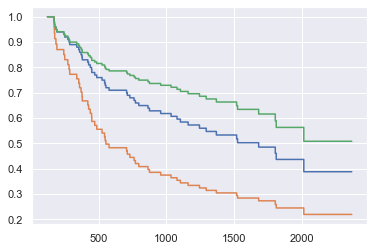

In [293]:
# print(wei, y_sub)
plt.step(bins_HO, sf1[0])
plt.step(bins_HO, sf2[0])
plt.step(bins_HO, sf3[0])

In [304]:
sf1.shape

(100, 2253)

In [306]:
sf1[0][np.searchsorted(bins_HO, y_sub["time"])-1]

array([0.46128117, 0.43700322, 0.7       , 0.48555913, 0.66985075,
       0.8       , 0.3884473 , 0.3884473 , 0.78      , 0.43700322,
       0.72      , 0.96      , 0.43700322, 0.43700322, 0.43700322,
       0.54741564, 0.71      , 0.48555913, 0.48555913, 0.64955224,
       0.50290053, 0.48555913, 0.48555913, 0.48555913, 0.84      ,
       0.59603032, 0.74      , 0.56014624, 0.53337934, 0.50290053,
       0.53337934, 0.53337934, 0.54741564, 0.54741564, 0.5845682 ,
       0.54741564, 0.65970149, 0.57287684, 0.57287684, 0.57287684,
       0.59603032, 0.59603032, 0.79      , 0.61810552, 0.64955224,
       0.3884473 , 0.3884473 , 0.9       , 0.43700322, 0.60706792,
       0.53337934, 0.48555913, 0.51813994, 1.        , 0.92      ,
       0.69      , 0.3884473 , 0.43700322, 0.43700322, 0.50290053,
       0.75      , 0.50290053, 0.88      , 0.48555913, 0.48555913,
       0.95      , 0.86      , 0.98      , 0.94      , 0.83      ,
       0.81      , 0.50290053, 0.61810552, 0.87      , 0.99   

In [318]:
sf

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [320]:
np.where(sf1 < 0.5)

(array([ 0,  0,  0, ..., 99, 99, 99], dtype=int64),
 array([1564, 1565, 1566, ..., 2250, 2251, 2252], dtype=int64))

In [313]:
np.where(sf1[0] < 0.5)[0][0]

1564

In [330]:
np.take_along_axis(sf1, (np.searchsorted(bins_HO, y_sub["time"])-1).reshape(-1, 1), axis=1).flatten()

array([0.46128117, 0.43700322, 0.7       , 0.48555913, 0.66985075,
       0.8       , 0.3884473 , 0.3884473 , 0.78      , 0.43700322,
       0.72      , 0.96      , 0.43700322, 0.43700322, 0.43700322,
       0.54741564, 0.71      , 0.48555913, 0.48555913, 0.64955224,
       0.50290053, 0.48555913, 0.48555913, 0.48555913, 0.84      ,
       0.59603032, 0.74      , 0.56014624, 0.53337934, 0.50290053,
       0.53337934, 0.53337934, 0.54741564, 0.54741564, 0.5845682 ,
       0.54741564, 0.65970149, 0.57287684, 0.57287684, 0.57287684,
       0.59603032, 0.59603032, 0.79      , 0.61810552, 0.64955224,
       0.3884473 , 0.3884473 , 0.9       , 0.43700322, 0.60706792,
       0.53337934, 0.48555913, 0.51813994, 1.        , 0.92      ,
       0.69      , 0.3884473 , 0.43700322, 0.43700322, 0.50290053,
       0.75      , 0.50290053, 0.88      , 0.48555913, 0.48555913,
       0.95      , 0.86      , 0.98      , 0.94      , 0.83      ,
       0.81      , 0.50290053, 0.61810552, 0.87      , 0.99   

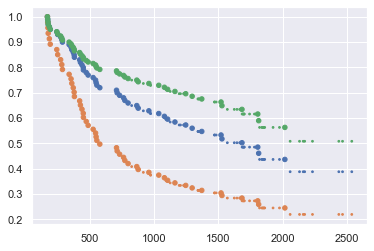

In [315]:
plt.scatter(y_sub["time"], sf1[0][np.searchsorted(bins_HO, y_sub["time"])-1], s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], sf2[0][np.searchsorted(bins_HO, y_sub["time"])-1], s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], sf3[0][np.searchsorted(bins_HO, y_sub["time"])-1], s=np.where(y_sub["cens"], 20, 3))

IndexError: index 0 is out of bounds for axis 0 with size 0

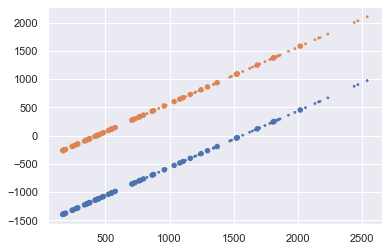

In [314]:
plt.scatter(y_sub["time"], y_sub["time"] - np.where(sf1[0] < 0.5)[0][0], s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], y_sub["time"] - np.where(sf2[0] < 0.5)[0][0], s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], y_sub["time"] - np.where(sf3[0] < 0.5)[0][0], s=np.where(y_sub["cens"], 20, 3))

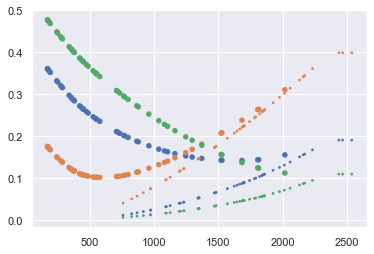

In [297]:
# plt.scatter(wei, ibs_full1, s=np.where(y_sub["cens"], 20, 3))
# plt.scatter(wei, ibs_full2, s=np.where(y_sub["cens"], 20, 3))

# print(ibs_full1.mean(), ibs_full2.mean(), ibs_full3.mean())
plt.scatter(y_sub["time"], ibs_full1, s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], ibs_full2, s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], ibs_full3, s=np.where(y_sub["cens"], 20, 3))

# plt.scatter(ibs_full1, ibs_full1, s=np.where(y_sub["cens"], 20, 3))
# plt.scatter(ibs_full1, ibs_full2, s=np.where(y_sub["cens"], 20, 3))
# plt.scatter(ibs_full2, ibs_full3, s=np.where(y_sub["cens"], 20, 3))

In [288]:
bins_HO[np.where(sf1[0] <= 0.5)[0]][0], bins_HO[np.where(sf2[0] <= 0.5)[0]][0] 

(1684, 554)

In [290]:
np.dot(wei[y_sub["cens"]], y_sub[y_sub["cens"]]["time"])/np.sum(wei[y_sub["cens"]]),
np.dot(np.ones_like(wei[y_sub["cens"]]), y_sub[y_sub["cens"]]["time"])/np.sum(np.ones_like(wei[y_sub["cens"]]))

(581.6467142479067, 711.843137254902)

In [100]:
weights = np.random.rand(y_sub["time"].shape[0]) # np.where(y_sub["cens"], 1, 0.5) # np.ones(y_sub["time"].shape[0])
dur_ = np.searchsorted(bins_HO, y_sub["time"])
hist_dur = np.bincount(dur_, weights=weights)
hist_cens = np.bincount(dur_, weights=y_sub["cens"]*weights)
cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]

hist_cens, cumul_hist_dur

(array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.89345415]),
 array([2.49726271, 2.49726271, 2.49726271, ..., 0.89345415, 0.89345415,
        0.89345415]))

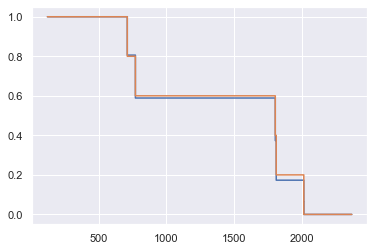

In [107]:
plt.step(bins_HO, sf_na[0])
plt.step(bins_HO, sf[0])

In [386]:
class KaplanMeierBal:
    def __init__(self):
        self.timeline = None
        self.survival_function = None
        self.confidence_interval_ = None
        self.alpha = 0.05

    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)
#         dis_coef = 1
        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_, weights=weights)
        self.hist_cens = np.bincount(dur_, weights=right_censor*weights)
        
#         if np.sum(right_censor) > 0:
#             dis_coef = (right_censor.shape[0] - np.sum(right_censor)) / np.sum(right_censor)
        
#         if int(dis_coef) > 1:
#             dis_coef = int(dis_coef)
#             hist_dur = hist_dur + (dis_coef - 1) * self.hist_cens
#             self.hist_cens = self.hist_cens * dis_coef
#         elif dis_coef != 0:
#             if int(1/dis_coef) > 1:
#                 cens_dc = int(1/dis_coef)
#                 hist_dur = (cens_dc - 1) * hist_dur + self.hist_cens
#                 self.hist_cens = self.hist_cens * cens_dc
                
        self.cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])
        self.survival_function = (self.survival_function - np.min(self.survival_function))/(np.max(self.survival_function) - np.min(self.survival_function))

    def count_confidence_interval(self):
        ''' exponential Greenwood: https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf '''
        z = ss.norm.ppf(1 - self.alpha / 2)
        cumulative_sq_ = np.sqrt(np.hstack([0.0, np.cumsum(self.hist_cens / (self.cumul_hist_dur * (self.cumul_hist_dur - self.hist_cens)))]))
        np.nan_to_num(cumulative_sq_, copy=False, nan=0)
        v = np.log(self.survival_function)
        np.nan_to_num(v, copy=False, nan=0)
        self.confidence_interval_ = np.vstack([np.exp(v * np.exp(- z * cumulative_sq_ / v)),
                                               np.exp(v * np.exp(+ z * cumulative_sq_ / v))]).T
        np.nan_to_num(self.confidence_interval_, copy=False, nan=1)

    def get_confidence_interval_(self):
        if self.confidence_interval_ is None:
            self.count_confidence_interval()
        return self.confidence_interval_

    def survival_function_at_times(self, times):
        place_bin = np.digitize(times, self.timeline)
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times < self.timeline[0]] = 1
        return sf

In [387]:
y_sub = y[:10].copy()

kmf1 = KaplanMeierZeroAfter()
kmf1.fit(y_sub["time"], y_sub["cens"])

dd = np.unique(y_sub["time"])
sf1 = kmf1.survival_function_at_times(bins_HO)
sf1 = np.repeat(sf1[np.newaxis, :], y.shape[0], axis=0)

ibs_full1 = ibs_WW(y, y, sf1, bins_HO, axis=0)
print(ibs_full1.mean(), auprc(y, y, sf1, bins_HO))

kmf2 = KaplanMeierBal()
kmf2.fit(y_sub["time"], y_sub["cens"])

dd = np.unique(y_sub["time"])
sf2 = kmf2.survival_function_at_times(bins_HO)
sf2 = np.repeat(sf2[np.newaxis, :], y.shape[0], axis=0)

ibs_full2 = ibs_WW(y, y, sf2, bins_HO, axis=0)
print(ibs_full2.mean(), auprc(y, y, sf2, bins_HO))

0.13694157761218498 0.6556862508957406
0.13773228060425283 0.6324443084569531


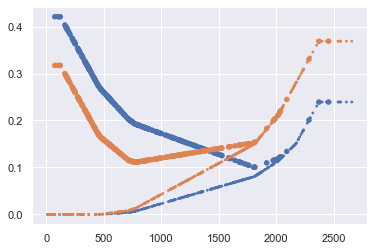

In [388]:
plt.scatter(y["time"], ibs_full1, s=np.where(y["cens"], 20, 3))
plt.scatter(y["time"], ibs_full2, s=np.where(y["cens"], 20, 3))

In [26]:
pred_haz.shape, pred_surv.shape, pred_time.shape

((459, 2253), (459, 2253), (459,))

In [330]:
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

tree_m = CRAID(features=features, criterion="logrank", depth=10, min_samples_leaf=0.05)
tree_m.fit(X_tr, y_tr)

pred_time = tree_m.predict(X_HO, target="time")
pred_surv = tree_m.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = tree_m.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))
tree_m.visualize(mode="surv")

[0.61012312 0.13046083 0.1874176  0.61815107 0.32847839 0.58533659]


In [349]:
tree_m = CRAID1(features=features, max_features=10, criterion="ibswei", depth=10, min_samples_leaf=0.05, n_jobs=1)
tree_m.fit(X_tr, y_tr)

pred_time1 = tree_m.predict(X_HO, target="time")
pred_surv1 = tree_m.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz1 = tree_m.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time1,
                   pred_surv1, pred_haz1, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

[0.6056283  0.11920462 0.16828329 0.6298669  0.3532528  0.59853171]


In [216]:
from survivors.ensemble import BootstrapCRAID
param_bstr = {'balance': None, 'categ': categ, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_WW', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, # 0.01 
        'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}

bstr = BootstrapCRAID(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.1128 0.0922 0.0805 0.0748 0.0738 0.0724 0.0694 0.0655 0.0636 0.0647
 0.0639 0.0628 0.0621 0.0607 0.0597 0.0594 0.0594 0.0584 0.0579 0.0581
 0.0579 0.0575 0.0567 0.0571 0.0571 0.0567 0.0559 0.056  0.0566 0.0564
 0.0561 0.0559 0.0559 0.0559 0.0558 0.0559 0.056  0.0562 0.0562 0.0562
 0.0557 0.0555 0.0556 0.0555 0.0553 0.0551 0.0553 0.0551 0.0552 0.0551]
fitted: 46 models.
[0.77498286 0.27658917 0.83267877 0.62887559 0.38769843 0.61425879]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in true_divide
  false_pos = cumsum_fp / n_controls


In [218]:
param_bstr = {'balance': None, 'categ': categ, 
    'criterion': 'ibswei', 'depth': 10, 'ens_metric_name': 'IBS_WW', 
    'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, # 0.01 
    'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}

bstr1 = BootstrapCRAID(**param_bstr)
bstr1.fit(X_tr, y_tr)
bstr1.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time1 = bstr1.predict(X_HO, target="time")
pred_surv1 = bstr1.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz1 = bstr1.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time1,
                   pred_surv1, pred_haz1, bins_HO, 
                   ['CI', "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.1024 0.0847 0.0841 0.0786 0.0746 0.0682 0.0667 0.0623 0.0619 0.0609
 0.0605 0.0591 0.0602 0.0598 0.059  0.0584 0.0576 0.0575 0.057  0.0571
 0.0568 0.0566 0.0564 0.056  0.0562 0.0558 0.0551 0.0552 0.0558 0.0555
 0.0554 0.0551 0.0553 0.0554 0.0552 0.0547 0.055  0.0552 0.0551 0.055
 0.0545 0.0546 0.0546 0.0543 0.0541 0.0542 0.0542 0.0542 0.0543 0.0542]
fitted: 45 models.
[0.79102125 0.28307675 0.84562969 0.62915785 0.38785378 0.61453336]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in true_divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.61708032 0.10647576 0.14558612 0.66939811 0.49017465 0.64909545]


In [ ]:
[0.62431112 0.10494258 0.14357879 0.66784064 0.4888831  0.64756811]


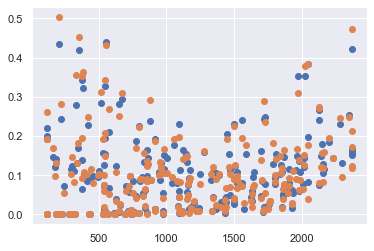

In [261]:
plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0))
plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, pred_surv1, bins_HO, axis=0))

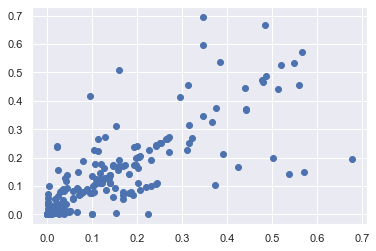

In [103]:
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0),
            metr.ibs_WW(y_tr, y_HO, pred_surv1, bins_HO, axis=0))

In [138]:
from survivors.ensemble import ProbBoostingCRAID
param_bstr = {'aggreg_func': 'wei', "with_arc": False, 
              'balance': None, 'categ': categ, "all_weight": True, 
                'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_WW', 
                'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, # 0.01 
                'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}
prbst = ProbBoostingCRAID(**param_bstr)
prbst.fit(X_tr, y_tr)
prbst.tolerance_find_best(param_bstr["ens_metric_name"])
pr_pred_time = prbst.predict(X_HO, target="time")
pr_pred_surv = prbst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pr_pred_haz = prbst.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pr_pred_time,
                   pr_pred_surv, pr_pred_haz, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.1717 0.1819 0.1789 0.1721 0.1651 0.1583 0.151  0.1508 0.1465 0.1429
 0.1408 0.1385 0.1373 0.1362 0.1345 0.1329 0.132  0.1319 0.1307 0.13
 0.1309 0.1302 0.1295 0.1293 0.1288 0.1284 0.128  0.1278 0.128  0.1276
 0.1271 0.1265 0.1261 0.1262 0.1264 0.127  0.1265 0.1259 0.126  0.1258
 0.1253 0.1255 0.1253 0.1257 0.1256 0.1257 0.1253 0.1251 0.125  0.1246]
fitted: 50 models.
[0.61692398 0.11074482 0.1506981  0.65231577 0.50020981 0.63508501]


In [212]:
from survivors.ensemble import BoostingCRAID
param_bstr = {'aggreg_func': 'wei', "with_arc": False, 'weighted_tree': False,
              'balance': None, 'categ': categ, "all_weight": False, "mode_wei": 'exp',
                'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_WW', 
                'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, # 0.01 
                'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}
prbst = BoostingCRAID(**param_bstr)
prbst.fit(X_tr, y_tr)
prbst.tolerance_find_best(param_bstr["ens_metric_name"])
pr_pred_time = prbst.predict(X_HO, target="time")
pr_pred_surv = prbst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pr_pred_haz = prbst.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pr_pred_time,
                   pr_pred_surv, pr_pred_haz, bins_HO, 
                   ['CI', "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.0967 0.1104 0.0975 0.0911 0.0832 0.0788 0.0773 0.0763 0.0743 0.0729
 0.0708 0.0676 0.0673 0.067  0.067  0.0652 0.0644 0.0638 0.0634 0.0634
 0.0618 0.0619 0.0615 0.0618 0.0613 0.0615 0.0603 0.0601 0.0601 0.0594
 0.0591 0.0591 0.0591 0.0592 0.0589 0.0594 0.0593 0.059  0.0582 0.0583
 0.0582 0.0584 0.0584 0.0579 0.0576 0.0576 0.0577 0.0575 0.0578 0.0577]
fitted: 48 models.
[0.79294037 0.28658465 0.82395652 0.6304506  0.3936218  0.61609734]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in true_divide
  false_pos = cumsum_fp / n_controls


In [511]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
param_est = {'learning_rate': 0.5, 'loss': 'coxph', 
              'max_depth': 20, 'max_features': 'sqrt', 
              'min_samples_leaf': 20, 'n_estimators': 50, 'random_state': 123}

est = GradientBoostingSurvivalAnalysis(**param_est)
X_tr_sks = X_tr.fillna(0).replace(np.nan, 0)
X_HO_sks = X_HO.fillna(0).replace(np.nan, 0)

est = est.fit(X_tr_sks, y_tr)
survs = est.predict_survival_function(X_HO_sks)
hazards = est.predict_cumulative_hazard_function(X_HO_sks)
pred_surv_bstr = np.array(list(map(lambda x: x(bins_HO), survs)))
pred_haz_bstr = np.array(list(map(lambda x: x(bins_HO), hazards)))
pred_time_bstr = -1*est.predict(X_HO_sks)

print(count_metric(y_tr, y_HO, pred_time_bstr,
                   pred_surv_bstr, pred_haz_bstr, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

[0.76648389 0.07498097 0.15278268 0.90538213 0.7196812  0.46516121
 0.70425574]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.76867718 0.07109125 0.14426503 0.88881791 0.72471607 0.4631848 0.70886569]

In [47]:
d = dict(zip(features, est.feature_importances_))
d_ = dict(sorted(d.items(), key=lambda item: -item[1]))
d_

{'min_Hypersensitive_c_reactive_protein': 0.10190084653988787,
 'mean_monocytes___': 0.08247193707951003,
 'max_Hypersensitive_cardiac_troponinI': 0.05853090952782764,
 'max_eosinophils___': 0.04925768892618368,
 'max_lymphocyte_count': 0.03517026196261217,
 'mean_D_D_dimer': 0.02853566376659282,
 'max_monocytes___': 0.024030219228590034,
 'mean_Total_cholesterol': 0.02313379359198268,
 'max_Platelet_count': 0.020379667914742085,
 'mean_Lactate_dehydrogenase': 0.019753148989019278,
 'min_neutrophils___': 0.019588222960140216,
 'mean_neutrophils_count': 0.01958468415379164,
 'max_Total_cholesterol': 0.019084566486209865,
 'max____lymphocyte': 0.01849156930754082,
 'age': 0.016330072378730104,
 'min_White_blood_cell_count': 0.015989480041369502,
 'mean_Hypersensitive_c_reactive_protein': 0.015562503445441,
 'max_thrombocytocrit': 0.013641484318568738,
 'min_Total_bilirubin': 0.012087129523405777,
 'min_neutrophils_count': 0.011310511305341156,
 'max_albumin': 0.010977335151444837,
 'max_

0.7247160684094913 0.2935713435900702


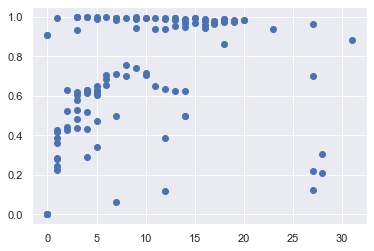

In [512]:
ibs_vals = metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals)
print(np.mean(ibs_vals), np.std(ibs_vals))

UNIQUE (0):177, DIST: [134  95]


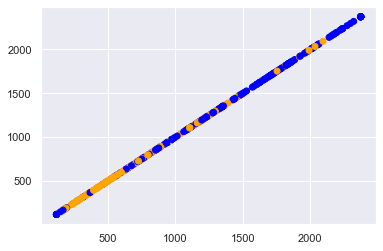

UNIQUE (1):188, DIST: [130  99]


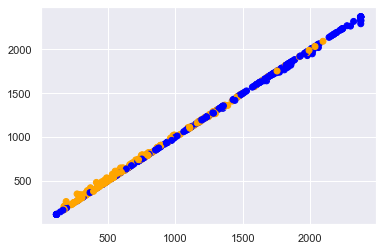

UNIQUE (2):171, DIST: [128 101]


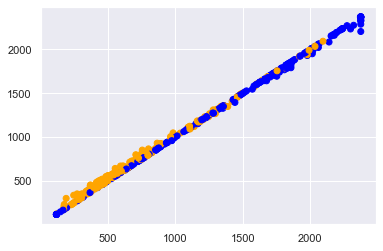

UNIQUE (3):172, DIST: [116 113]


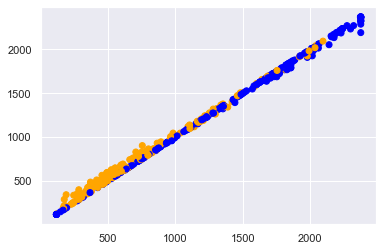

UNIQUE (4):184, DIST: [124 105]


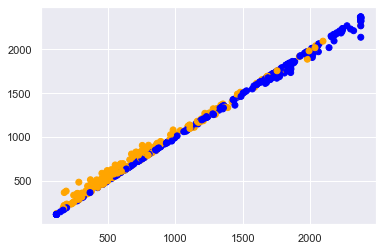

UNIQUE (5):183, DIST: [128 101]


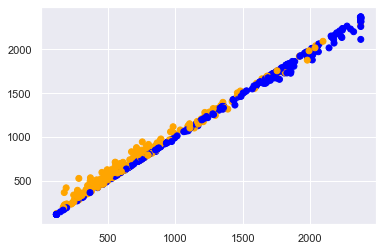

UNIQUE (6):183, DIST: [141  88]


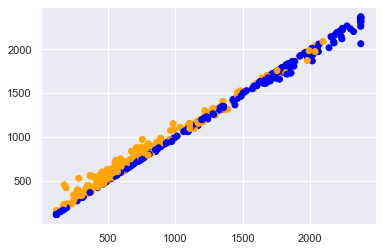

UNIQUE (7):178, DIST: [128 101]


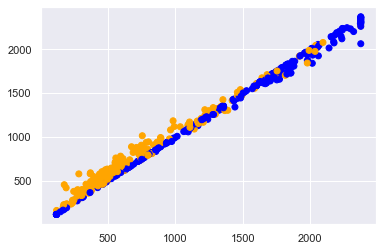

UNIQUE (8):186, DIST: [128 101]


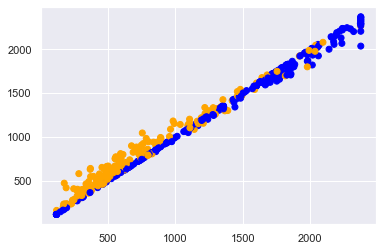

UNIQUE (9):175, DIST: [130  99]


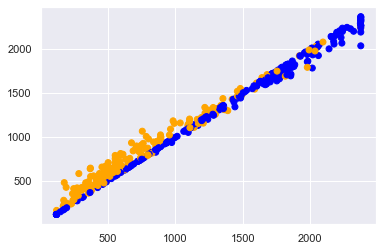

UNIQUE (10):177, DIST: [129 100]


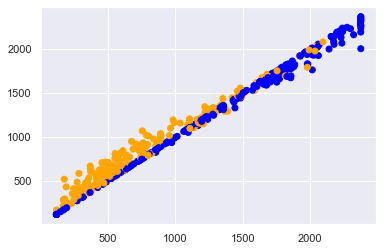

UNIQUE (11):167, DIST: [115 114]


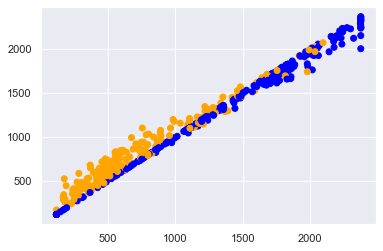

UNIQUE (12):178, DIST: [126 103]


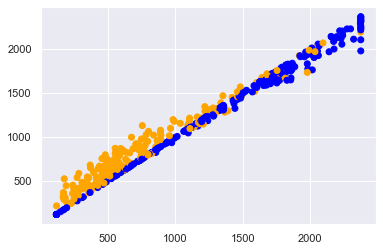

UNIQUE (13):182, DIST: [132  97]


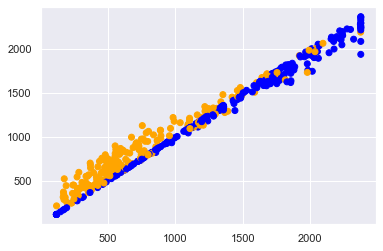

UNIQUE (14):181, DIST: [117 112]


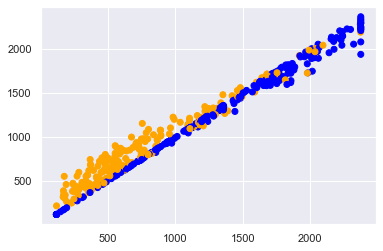

UNIQUE (15):180, DIST: [129 100]


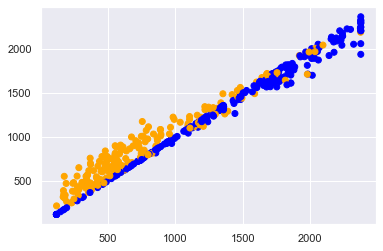

UNIQUE (16):183, DIST: [132  97]


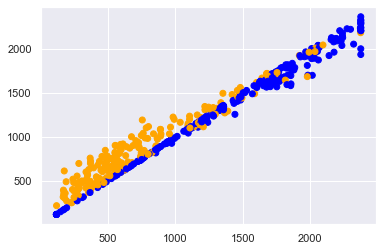

UNIQUE (17):178, DIST: [130  99]


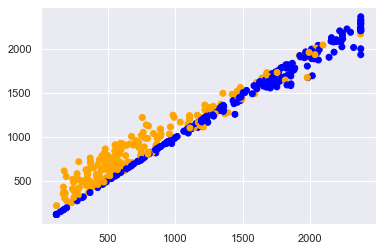

UNIQUE (18):172, DIST: [134  95]


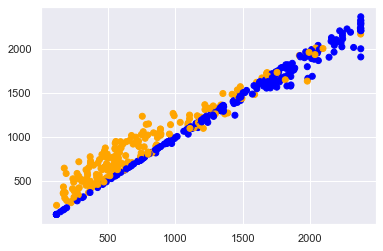

UNIQUE (19):186, DIST: [130  99]


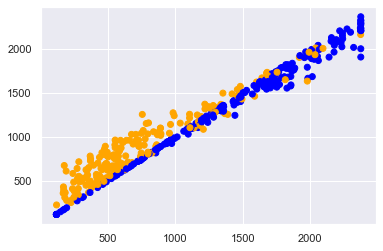

UNIQUE (20):185, DIST: [135  94]


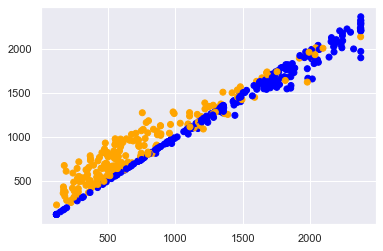

UNIQUE (21):175, DIST: [118 111]


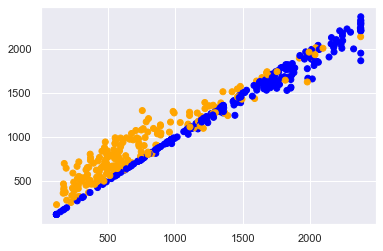

UNIQUE (22):181, DIST: [124 105]


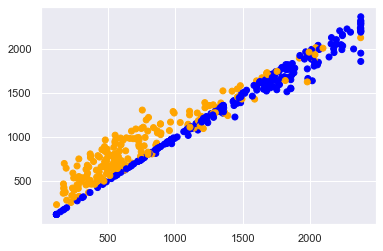

UNIQUE (23):175, DIST: [125 104]


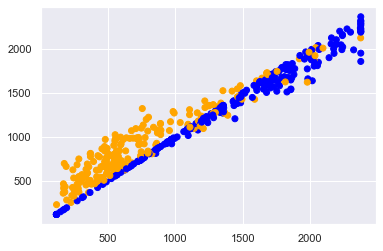

UNIQUE (24):185, DIST: [131  98]


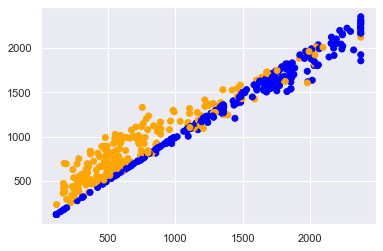

UNIQUE (25):186, DIST: [133  96]


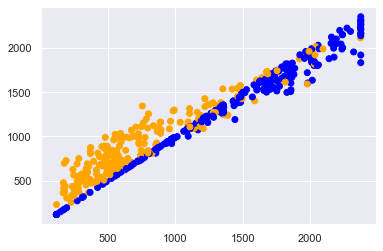

UNIQUE (26):175, DIST: [129 100]


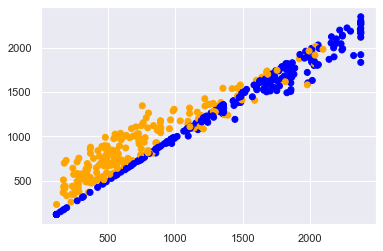

UNIQUE (27):185, DIST: [121 108]


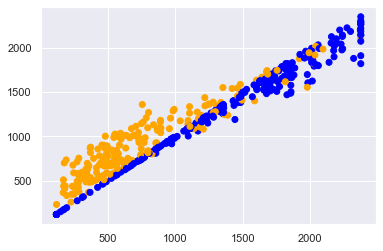

UNIQUE (28):181, DIST: [126 103]


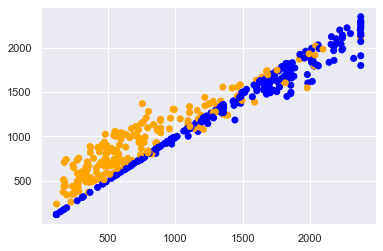

UNIQUE (29):186, DIST: [122 107]


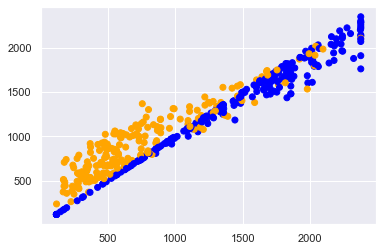

UNIQUE (30):178, DIST: [136  93]


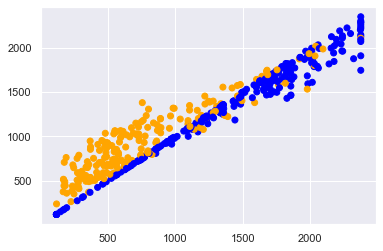

UNIQUE (31):176, DIST: [116 113]


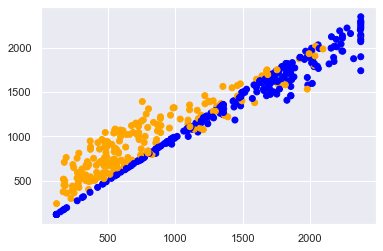

UNIQUE (32):185, DIST: [135  94]


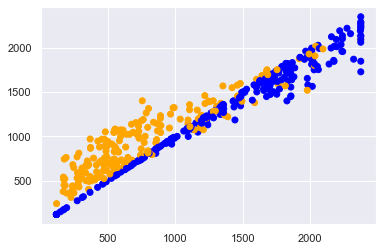

UNIQUE (33):189, DIST: [125 104]


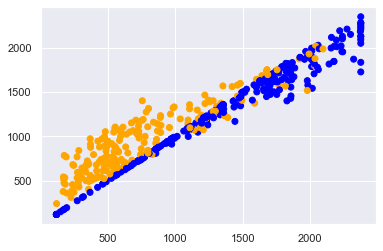

UNIQUE (34):176, DIST: [132  97]


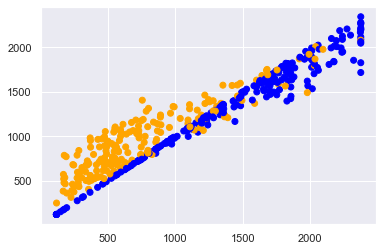

UNIQUE (35):174, DIST: [123 106]


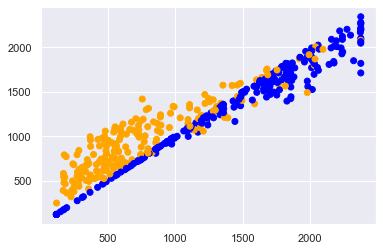

UNIQUE (36):179, DIST: [132  97]


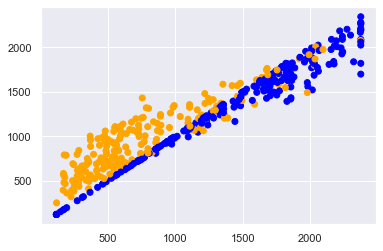

UNIQUE (37):180, DIST: [129 100]


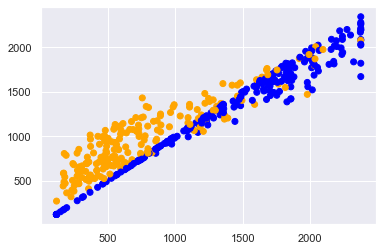

UNIQUE (38):184, DIST: [142  87]


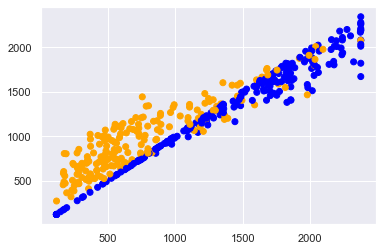

UNIQUE (39):179, DIST: [133  96]


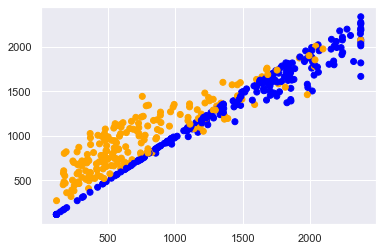

UNIQUE (40):178, DIST: [119 110]


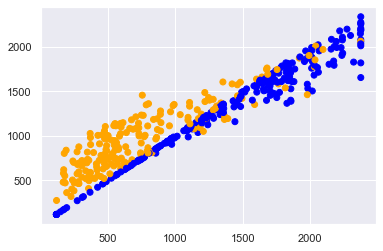

UNIQUE (41):186, DIST: [130  99]


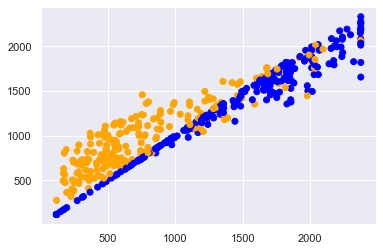

UNIQUE (42):177, DIST: [122 107]


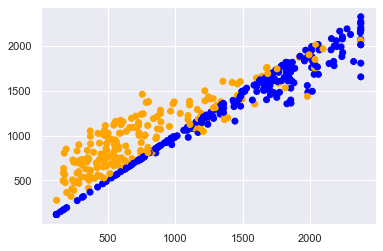

UNIQUE (43):173, DIST: [132  97]


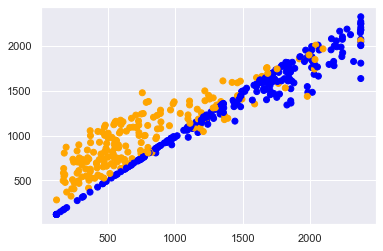

UNIQUE (44):177, DIST: [120 109]


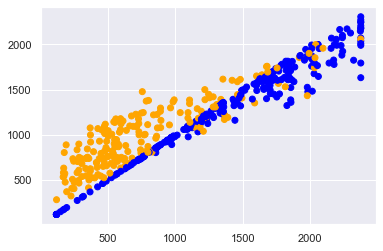

UNIQUE (45):179, DIST: [123 106]


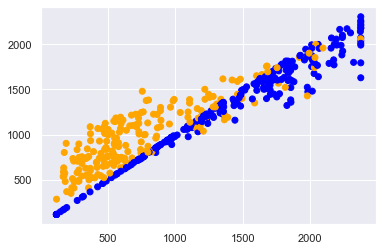

UNIQUE (46):183, DIST: [129 100]


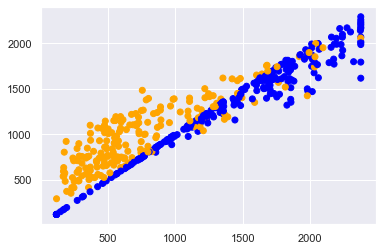

UNIQUE (47):181, DIST: [139  90]


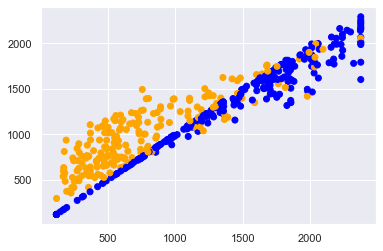

UNIQUE (48):182, DIST: [123 106]


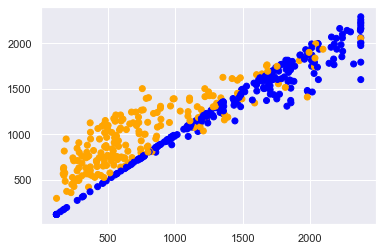

UNIQUE (49):188, DIST: [139  90]


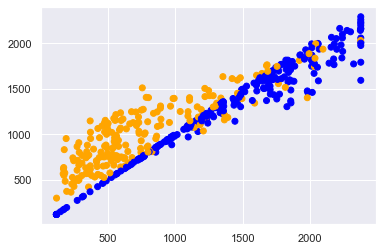

[0.2384 0.2212 0.196  0.1902 0.1806 0.1767 0.1737 0.1714 0.1677 0.1664
 0.1659 0.1653 0.1646 0.1633 0.1631 0.1624 0.1624 0.1613 0.1603 0.1604
 0.1605 0.1599 0.1596 0.1592 0.159  0.159  0.1589 0.1589 0.1586 0.1585
 0.1583 0.1584 0.1587 0.1587 0.1586 0.1587 0.1584 0.1583 0.1583 0.1581
 0.1581 0.1579 0.1578 0.1577 0.1576 0.1576 0.1577 0.1576 0.1576 0.1576]
fitted: 45 models.
[0.61829197 0.10674626 0.14629515 0.37302563 0.75679989 0.72305381
 0.54106211 0.70243756]


In [727]:
param = {'aggreg_func': 'wei', 'weighted_tree': False,
         'balance': None, 'categ': categ, 'all_weight': True,  # "only_log_rank"
         'criterion': 'peto', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 
         'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, 
         'n_estimators': 50, 'n_jobs': 1, 'size_sample': 0.5}

# param = {'aggreg_func': 'wei', 'weighted_tree': False,
#          'balance': None, 'categ': categ, 'all_weight': True,  # "only_log_rank"
#          'criterion': 'peto', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 
#          'leaf_model': 'base_fast', 'max_features': 0.3, 'min_samples_leaf': 0.05, 
#          'n_estimators': 50, 'n_jobs': 1, 'size_sample': 1.0}

bst = IBSCleverBoostingCRAID1(**param)
bst.fit(X_tr, y_tr)
bst.tolerance_find_best(param["ens_metric_name"])

pred_surv = bst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_time = bst.predict(X_HO, target=cnt.TIME_NAME)
pred_haz = bst.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time, 
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

In [ ]:
[0.61829197 0.10674626 0.14629515 0.37302563 0.75679989 0.72305381
 0.54106211 0.70243756]

In [ ]:
[0.77607951 0.05217564 0.07227308 0.13924877 0.86552461 0.70292791
 0.42100231 0.68584151]

In [ ]:
[0.76566141 0.05515452 0.07489702 0.1462262  0.86473855 0.70503936
 0.41670694 0.68756467]

In [ ]:
[0.7601782  0.04886587 0.06888839 0.12813492 0.90029203 0.67683953
 0.3892159  0.65940779]

In [ ]:
[0.80911583 0.04892541 0.06904    0.12325186 0.88567412 0.67987295
 0.3925011  0.66245647]

In [84]:
df[df["min_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_"] > 473][["min_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_", "cens"]]

,min_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_,cens
5,645.0,False
37,70000.0,False
40,11017.0,False
44,13006.0,False
59,885.0,False
...,...,...
365,2170.0,True
366,1029.0,True
369,2941.0,True
371,2568.0,True


In [589]:
bst.models[1].visualize(mode="surv")

In [ ]:
[0.80911583 0.04892541 0.06904    0.12325186 0.88567412 0.67987295
 0.3925011  0.66245647]

[0.81034955 0.04914468 0.06954718 0.12530352 0.88259484 0.67759486
 0.38931385 0.66012328]

In [ ]:
[0.62278679 0.10448363 0.14378023 0.33201395 0.7578171  0.69019376
 0.51303588 0.67012509]

In [ ]:
param = {'aggreg_func': 'wei', 'weighted_tree': True,
         'balance': None, 'categ': categ, 'all_weight': True,  # "only_log_rank"
         'criterion': 'weights', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 
         'leaf_model': 'base_fast', 'max_features': 0.3, 'min_samples_leaf': 0.05, 
         'n_estimators': 100, 'n_jobs': 1, 'size_sample': 1.0}

[0.81172036 0.04935577 0.06994577 0.12587805 0.88561388 0.67656763
 0.38859076 0.65911449]

In [ ]:
[0.79718986 0.04992077 0.07067745 0.12626976 0.87837713 0.6817066
 0.39409409 0.66427554]

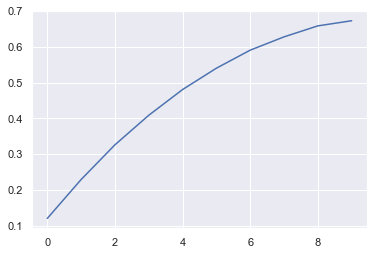

In [593]:
plt.plot(np.cumsum(np.ones_like(bst.bettas)) / np.cumsum(bst.bettas))

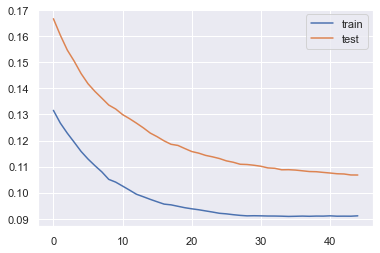

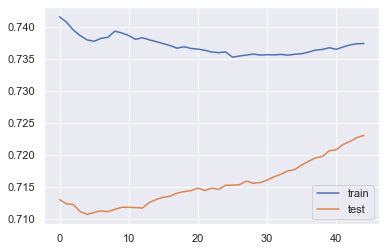

In [728]:
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "ibs")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "ibs")
plt.legend()
plt.show()
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "auprc")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "auprc")
plt.legend()

In [ ]:
## [0.79520219 0.07152668 0.12995207 0.86920129 0.67270816 0.38657166 0.65536655]

In [88]:
print(y_HO[y_HO["time"] > 25])
X_HO[(y_HO["time"] > 25) & (y_HO["cens"] == 1)].describe()

[( True, 27.) (False, 27.) ( True, 28.) ( True, 27.) (False, 31.)
 ( True, 27.) ( True, 28.)]


,mean_D_D_dimer,min_Lactate_dehydrogenase,min_mean_corpuscular_hemoglobin_,mean_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_,min___glutamyl_transpeptidase,mean_Lactate_dehydrogenase,min_monocytes___,mean_Serum_potassium,mean_Thrombin_time,min_PH_value,...,mean_creatinine,max_basophil___,min_neutrophils_count,max_neutrophils_count,max_Platelet_count,min_glutamic_pyruvic_transaminase,min_indirect_bilirubin,max_HCV_antibody_quantification,max_hematocrit,max_Corrected_calcium
count,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.00000,4.000,...,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000,5.000000,5.000000
mean,14.738667,485.200000,30.720000,1480.770833,22.600000,590.650000,2.460000,4.851167,23.92500,5.875,...,85.55000,0.180000,9.214000,16.732000,142.800000,17.600000,5.040000,0.105,38.800000,2.432000
std,7.173902,155.058699,1.564289,1858.207496,19.565275,264.514508,2.319052,0.492005,9.29358,0.250,...,41.53327,0.083666,5.963408,8.988252,69.765321,8.848729,2.166333,0.050,7.049113,0.123976
min,3.310000,291.000000,29.200000,394.750000,3.000000,376.000000,0.600000,4.130000,15.42500,5.500,...,29.00000,0.100000,5.410000,9.760000,56.000000,5.000000,1.700000,0.050,30.300000,2.220000
25%,12.225000,381.000000,29.200000,572.187500,13.000000,448.000000,1.200000,4.622500,19.40000,5.875,...,71.75000,0.100000,5.650000,11.130000,81.000000,13.000000,4.000000,0.080,35.900000,2.440000
50%,18.245000,487.000000,31.000000,632.666667,21.000000,495.500000,1.500000,5.020000,22.30000,6.000,...,79.00000,0.200000,7.160000,11.840000,171.000000,20.000000,6.200000,0.100,38.300000,2.460000
75%,18.913333,591.000000,31.300000,1541.250000,21.000000,591.000000,2.600000,5.065000,22.80000,6.000,...,108.00000,0.200000,8.160000,19.690000,197.000000,22.000000,6.600000,0.125,39.900000,2.510000
max,21.000000,676.000000,32.900000,4263.000000,55.000000,1042.750000,6.400000,5.418333,39.70000,6.000,...,140.00000,0.300000,19.690000,31.240000,209.000000,28.000000,6.700000,0.170,49.600000,2.530000


In [89]:
X_HO[(y_HO["time"] > 25) & (y_HO["cens"] == 0)].describe()

,mean_D_D_dimer,min_Lactate_dehydrogenase,min_mean_corpuscular_hemoglobin_,mean_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_,min___glutamyl_transpeptidase,mean_Lactate_dehydrogenase,min_monocytes___,mean_Serum_potassium,mean_Thrombin_time,min_PH_value,...,mean_creatinine,max_basophil___,min_neutrophils_count,max_neutrophils_count,max_Platelet_count,min_glutamic_pyruvic_transaminase,min_indirect_bilirubin,max_HCV_antibody_quantification,max_hematocrit,max_Corrected_calcium
count,1.00,2.000000,2.000000,0.0,2.00000,2.000000,2.000000,2.000000,2.000000,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,0.0,2.000000,2.000000
mean,0.83,174.000000,31.400000,NaN,23.00000,183.500000,8.350000,4.015833,16.300000,6.5,...,50.500000,0.250000,2.615000,3.475000,333.500000,10.500000,4.80000,NaN,35.000000,2.315000
std,NaN,90.509668,0.424264,NaN,19.79899,95.459415,2.474874,0.097816,1.272792,0.0,...,4.949747,0.070711,1.718269,0.502046,103.944697,6.363961,2.12132,NaN,1.697056,0.190919
min,0.83,110.000000,31.100000,NaN,9.00000,116.000000,6.600000,3.946667,15.400000,6.5,...,47.000000,0.200000,1.400000,3.120000,260.000000,6.000000,3.30000,NaN,33.800000,2.180000
25%,0.83,142.000000,31.250000,NaN,16.00000,149.750000,7.475000,3.981250,15.850000,6.5,...,48.750000,0.225000,2.007500,3.297500,296.750000,8.250000,4.05000,NaN,34.400000,2.247500
50%,0.83,174.000000,31.400000,NaN,23.00000,183.500000,8.350000,4.015833,16.300000,6.5,...,50.500000,0.250000,2.615000,3.475000,333.500000,10.500000,4.80000,NaN,35.000000,2.315000
75%,0.83,206.000000,31.550000,NaN,30.00000,217.250000,9.225000,4.050417,16.750000,6.5,...,52.250000,0.275000,3.222500,3.652500,370.250000,12.750000,5.55000,NaN,35.600000,2.382500
max,0.83,238.000000,31.700000,NaN,37.00000,251.000000,10.100000,4.085000,17.200000,6.5,...,54.000000,0.300000,3.830000,3.830000,407.000000,15.000000,6.30000,NaN,36.200000,2.450000


In [121]:
import statsmodels.api as sm

model = sm.OLS(y["time"], X.fillna(0).replace(np.nan, 0))
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.894
Method:                 Least Squares   F-statistic:                              15.52
Date:                Mon, 11 Sep 2023   Prob (F-statistic):                    2.03e-55
Time:                        21:14:08   Log-Likelihood:                         -903.57
No. Observations:                 375   AIC:                                      2241.
Df Residuals:                     158   BIC:                                      3093.
Df Model:                         217                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
mean_D_D_dimer                                                         1.4571      0.801      1.819      0.071      -0.125       3.040
min_Lactate_dehydrogenase                                              0.0249      0.016      1.571      0.118      -0.006       0.056
min_mean_corpuscular_hemoglobin_                                      -1.6160      2.535     -0.637      0.525      -6.624       3.392
mean_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_    -0.0018      0.001     -1.640      0.103      -0.004       0.000
min___glutamyl_transpeptidase                                         -0.0737      0.099     -0.743      0.458      -0.269       0.122
mean_Lactate_dehydrogenase                                            -0.0399      0.028     -1.411      0.160      -0.096       0.016
min_monocytes___                                                       0.1393      0.922      0.151      0.880      -1.682       1.960
mean_Serum_potassium                                                  -2.9596      5.619     -0.527      0.599     -14.057       8.138
mean_Thrombin_time                                                    -0.7328      0.434     -1.687      0.094      -1.591       0.125
min_PH_value                                                          -3.1076      3.837     -0.810      0.419     -10.685       4.470
min_eosinophils___                                                    -0.4495      3.375     -0.133      0.894      -7.115       6.216
mean_monocytes_count                                                 -37.5291     19.517     -1.923      0.056     -76.076       1.018
max_Interleukin_1_                                                     6.1228      3.631      1.686      0.094      -1.049      13.295
mean_thrombocytocrit                                                 292.5651    103.183      2.835      0.005      88.769     496.361
max_mean_corpuscular_hemoglobin_                                      -2.2138      2.442     -0.907      0.366      -7.036       2.608
mean_basophil___                                                      19.9993     23.691      0.844      0.400     -26.793      66.791
mean_Prothrombin_activity                                              0.3134      0.741      0.423      0.673      -1.149       1.776
min_Activation_of_partial_thromboplastin_time                          0.0944      0.593      0.159      0.874      -1.078       1.266
max_albumin                                                            0.3742      0.624      0.600      0.550      -0.858       1.607
mean___glutamy

In [90]:
df[["mean_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_", "cens"]].value_counts()

mean_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_  cens 
5.0                                                                 False    9
9.0                                                                 False    4
23.0                                                                False    4
26.0                                                                False    3
125.0                                                               False    3
                                                                            ..
258.0                                                               True     1
265.0                                                               True     1
267.0                                                               False    1
267.5                                                               True     1
70000.0                                                             False    1
Name: count, Length: 234, dtype: int64

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_22240\1084264248.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df.reset_index(drop=True), x="mean_thrombocytocrit", y="time", palette="deep")


<Axes: xlabel='mean_thrombocytocrit', ylabel='time'>

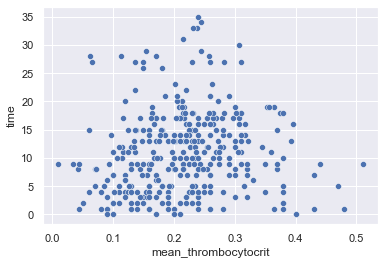

In [130]:
sns.scatterplot(df.reset_index(drop=True), x="mean_thrombocytocrit", y="time", palette="deep")

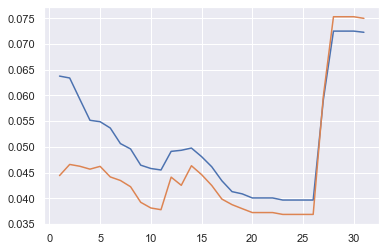

In [510]:
l1 = []
l2 = []
for b in bins_HO[1:]:
    ind = np.where(y_HO["time"] <= b)
    l1.append(metr.ibs_remain(y_tr, y_HO[ind], pred_surv[ind], bins_HO))
    l2.append(metr.ibs_remain(y_tr, y_HO[ind], pred_surv_bstr[ind], bins_HO))
plt.plot(bins_HO[1:], l1)
plt.plot(bins_HO[1:], l2)

In [ ]:
[0.617393   0.14809655 0.34428443 0.75925409 0.68397882 0.50880313 0.6641347 ]

In [ ]:
[0.62384209 0.14637976 0.34313499 0.77219706 0.67969879 0.50319173 0.65970385]

In [ ]:
[0.62904045 0.14410236 0.3889508  0.75498701 0.68365474 0.5262897 0.66582823]

[0.63443424 0.14384832 0.34170951 0.76274264 0.68895888 0.50904109 0.66857756]

In [130]:
# [0.80020562 0.06946576 0.12550715 0.88966621 0.67995909 0.39606099
#  0.66275315]

# [0.80089102 0.06919537 0.12511141 0.89019215 0.68100682 0.39766488
#  0.66383458]

In [87]:
[0.80089102 0.06919537 0.12511141 0.89019215 0.68100682 0.39766488 0.66383458]

[0.80020562 0.12550715 0.88966621 0.67995909 0.39606099 0.66275315]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (115590197.py, line 1)

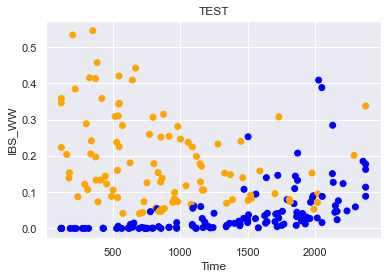

0.10671571023924263 0.1186382523687014
0.0910229087253998 0.10259301903655439


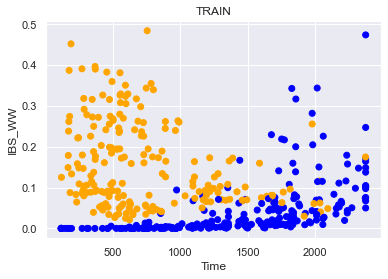

In [729]:
ibs_vals = metr.ibs_remain(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
plt.title("TEST")
plt.xlabel("Time")
plt.ylabel("IBS_WW")
plt.show()
print(np.mean(ibs_vals), np.std(ibs_vals))

pred_sv_tr = bst.predict_at_times(X_tr, bins=bins_HO, mode="surv")
ibs_vals = metr.ibs_remain(y_tr, y_tr, pred_sv_tr, bins_HO, axis=0)
plt.scatter(y_tr["time"], ibs_vals, c=np.where(y_tr["cens"], "orange", "blue"))
plt.title("TRAIN")
plt.xlabel("Time")
plt.ylabel("IBS_WW")
print(np.mean(ibs_vals), np.std(ibs_vals))

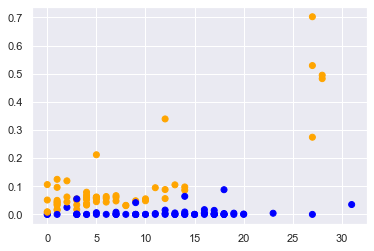

0.05097529813959088 0.10544346815571064
0.020694938589786303 0.037691177156624886


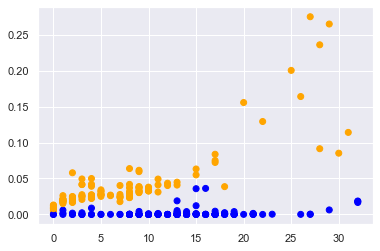

In [197]:
ibs_vals = metr.ibs_remain(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
plt.show()
print(np.mean(ibs_vals), np.std(ibs_vals))

pred_sv_tr = bst.predict_at_times(X_tr, bins=bins_HO, mode="surv")
ibs_vals = metr.ibs_remain(y_tr, y_tr, pred_sv_tr, bins_HO, axis=0)
plt.scatter(y_tr["time"], ibs_vals, c=np.where(y_tr["cens"], "orange", "blue"))
print(np.mean(ibs_vals), np.std(ibs_vals))

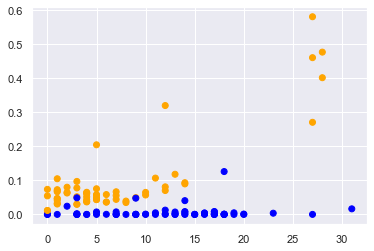

0.04894028476067681 0.09339234955985573
0.03430501106687711 0.06339195162398799


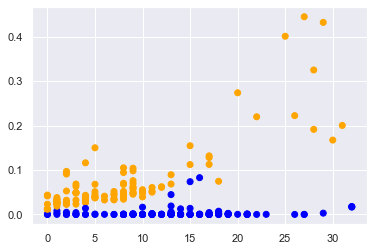

In [544]:
ibs_vals = metr.ibs_remain(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
plt.show()
print(np.mean(ibs_vals), np.std(ibs_vals))

pred_sv_tr = bst.predict_at_times(X_tr, bins=bins_HO, mode="surv")
ibs_vals = metr.ibs_remain(y_tr, y_tr, pred_sv_tr, bins_HO, axis=0)
plt.scatter(y_tr["time"], ibs_vals, c=np.where(y_tr["cens"], "orange", "blue"))
print(np.mean(ibs_vals), np.std(ibs_vals))

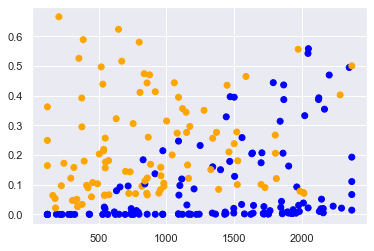

0.14854650462989957 0.16433363838759357
0.03772979535827485 0.05579106223851466


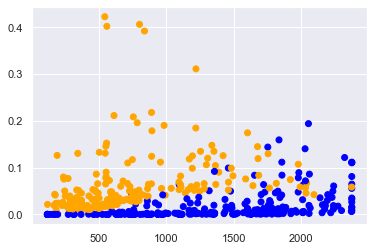

In [321]:
ibs_vals = metr.ibs_remain(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
plt.show()
print(np.mean(ibs_vals), np.std(ibs_vals))

pred_sv_tr = bst.predict_at_times(X_tr, bins=bins_HO, mode="surv")
ibs_vals = metr.ibs_remain(y_tr, y_tr, pred_sv_tr, bins_HO, axis=0)
plt.scatter(y_tr["time"], ibs_vals, c=np.where(y_tr["cens"], "orange", "blue"))
print(np.mean(ibs_vals), np.std(ibs_vals))

0.6834555420578304 0.22302725393710263


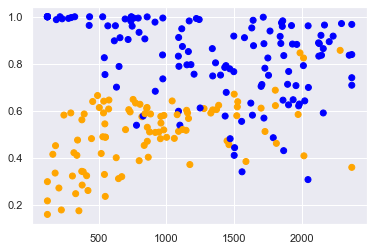

In [314]:
ibs_vals = metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
print(np.mean(ibs_vals), np.std(ibs_vals))

In [ ]:
GBSG 0.10520 0.09359

In [ ]:
[0.62458472 0.14642696 0.33393545 0.77167726 0.68903982 0.50546998 0.6682448 ]

[0.61219465 0.14676605 0.3704488  0.75069901 0.68089246 0.51223358 0.66178657]

In [ ]:
[0.62454563 0.16316924 0.31681772 0.76381182 0.68671327 0.48745588 0.66414114] # wei base_fast
[0.61864374 0.16558463 0.31666503 0.76349835 0.68477513 0.48610323 0.66226933] # mean base_fast

[0.62532734 0.14605382 0.33177793 0.76701593 0.68692525 0.50427755 0.66623469] # mean base_zero_after
[0.62161423 0.14433037 0.33712839 0.77097816 0.68708272 0.50941252 0.66695602] # wei base_zero_after

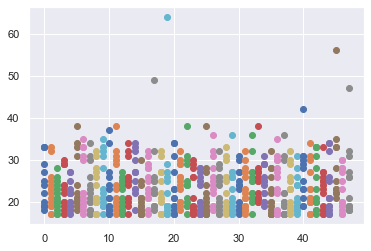

In [355]:
for m_i, b in enumerate(bst.models):
    l = []
    for i, n in b.nodes.items():
        if n.is_leaf:
            l.append(n.leaf_model.shape[0])
    
    plt.scatter(x=np.ones_like(l)*m_i, y=l)

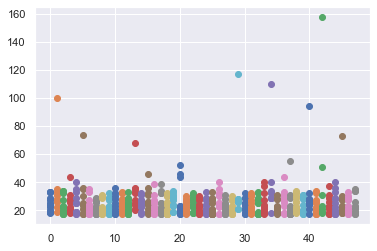

In [353]:
for m_i, b in enumerate(bst.models):
    l = []
    for i, n in b.nodes.items():
        if n.is_leaf:
            l.append(n.leaf_model.shape[0])
    
    plt.scatter(x=np.ones_like(l)*m_i, y=l)

In [310]:
[0.78265936 0.19179243 0.85868291 0.65793649 0.36772733 0.64034806]
[0.78457848 0.13934414 0.87004602 0.65747228 0.36876048 0.63997459]

[0.80020562 0.12550715 0.88966621 0.67995909 0.39606099 0.66275315]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2637398283.py, line 1)

In [ ]:
[0.62016807 0.31981274 0.7676767  0.67971621 0.48581002 0.65775028] # base_fast with partial ens ibs as wei
[0.61031855 0.3421834  0.75881519 0.68310193 0.50573737 0.66300985] # base_zero_after with partial ens ibs as wei

In [ ]:
[0.6227477  0.31638412 0.77072591 0.68433562 0.48604648 0.66187318] # base_fast with mean ens ibs as wei
[0.62149697 0.33383418 0.77246182 0.68627578 0.50415848 0.6656453 ] # base_zero_after with mean ens ibs as wei

In [ ]:
[0.61872191 0.33394521 0.76483232 0.68241727 0.49935149 0.66167935]

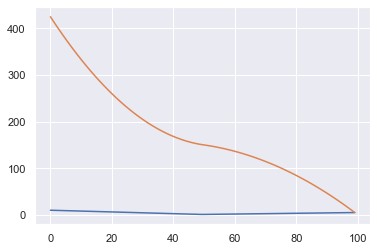

In [102]:
x = np.hstack([np.linspace(10, 1, 50), np.linspace(1, 5, 50)])
plt.plot(x)
plt.plot(np.cumsum(x[::-1])[::-1])

In [158]:
from scipy.optimize import linprog

obj = [0.3, 0.4, 0.77, 0.1, 0.2]

lhs_ineq = []  # левая сторона желтого неравенства
rhs_ineq = []

lhs_eq = [np.ones(len(obj))]  # левая сторона зеленого равенства
rhs_eq = [1]       # правая сторона зеленого равенства

bnd = list(zip(np.zeros(len(obj)), 
               np.ones(len(obj))))

opt = linprog(c=obj, # A_ub=lhs_ineq, b_ub=rhs_ineq,
              A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd,
              method="revised simplex")

opt

     con: array([0.])
     fun: 0.1
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([0., 0., 0., 1., 0.])

(array([ 32., 121., 203., 237., 208., 120.,  52.,  18.,   7.,   2.]),
 array([0.54798231, 0.56785832, 0.58773433, 0.60761034, 0.62748634,
        0.64736235, 0.66723836, 0.68711437, 0.70699038, 0.72686639,
        0.7467424 ]),
 <BarContainer object of 10 artists>)

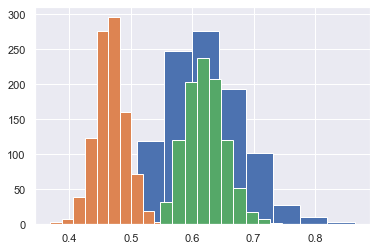

In [159]:
n = 50

def get_sum_sqrt_rand1(ibss_):
    a = np.random.rand(n)
    a = a / np.sum(a)
    return np.sum(ibss_) * np.sum(a**2)

def get_sum_sqrt_rand2(ibss_):
    a = np.random.rand(n)
    a = a / np.sum(a)
    return np.dot(ibss_, a) * np.sum(a)

def get_sum_sqrt_rand3(ibss_):
    a = np.random.rand(n)
    a = a / np.sum(a)
    return np.dot(ibss_, a**2) * a.shape[0]

np.random.seed(100)
ibss_ = np.random.rand(n)
plt.hist([get_sum_sqrt_rand3(ibss_) for i in range(1000)])
plt.hist([get_sum_sqrt_rand2(ibss_) for i in range(1000)])
plt.hist([get_sum_sqrt_rand1(ibss_) for i in range(1000)])

In [240]:
sfs_h = []
x_h = np.linspace(0.01, 3.0, 100)
for i in x_h:
    tm = np.clip(y[4]["time"]*i, bins_HO[0], bins_HO[-1])
    sfs_h.append(np.where(tm > bins_HO, 1, 0))

In [241]:
sfs_v = []
x_v = np.linspace(0.0, 0.5, 100)
for i in x_v:
    sfs_v.append(np.where(y[4]["time"] > bins_HO, 1 - i, i))

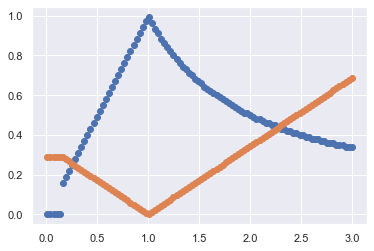

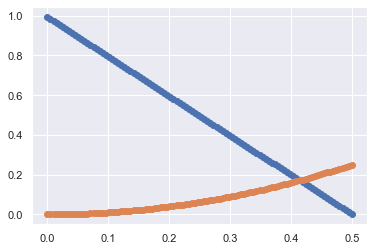

In [242]:
y_one = np.repeat(y[4], 100)

plt.scatter(x_h, metr.auprc(y_one, y_one, np.vstack(sfs_h), bins_HO, axis=0))
plt.scatter(x_h, metr.ibs_WW(y_one, y_one, np.vstack(sfs_h), bins_HO, axis=0))
plt.show()
plt.scatter(x_v, metr.auprc(y_one, y_one, np.vstack(sfs_v), bins_HO, axis=0))
plt.scatter(x_v, metr.ibs_WW(y_one, y_one, np.vstack(sfs_v), bins_HO, axis=0))
plt.show()